In [3]:
USE_CUDA = False
VERBOSE = False

In [39]:
if USE_CUDA:
    import cudf

    %load_ext cudf.pandas
import importlib
import workbench.src.data_loader as data_loader
import workbench.src.data_process as data_process
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import workbench.utils.utils as utils
from IPython.display import Markdown
from sklearn.model_selection import cross_val_score, train_test_split, GroupKFold, cross_val_predict, GroupShuffleSplit
import workbench.src.feature_select as feature_select
import pandas as pd
from typing import List, Dict
import workbench.src.shared as shared
import workbench.src.validation as validation
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from workbench.src import graph
from workbench.src import simulation
from workbench.src import model_config
from scipy.stats import f_oneway, linregress
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


In [5]:
utils.pandas_config(pd)
utils.plt_config(plt)

sns.set_theme(style="darkgrid", palette="pastel")
plt.style.use("fivethirtyeight")

In [6]:
xg_boost_params = {"device": "cuda"}

In [7]:
importlib.reload(data_loader)
data = data_loader.load_data(inc_players=True)

importlib.reload(data_process)
processed_data = data_process.append_rolling_match_team_stats(data)
dual_df = processed_data.dual_df
full_df = data_process.add_team_strategies(
    source_df=dual_df, team_attrs_df=data.team_attrs_df
)

### Model and Strategy

Using the insights from out exploratory analysis we'll to build an ML classification model which we can use to predict match results. We'll attempt to use that model to create a profitable betting strategy. 

#### Preparing Data

We will use the data available in the matches dataframe in combination wit the team strategies dataframe to build the training dataset. Specifically we'll use these features:

- Target Variable: Result (win/draw/loss)

Features:
- Time weighted Win % over N last matches
    - Also time weighted average goals scored, conceded and deficit per match
- Sum of player ratings (based on FIFA games) participating in the match
- Relative performance of teams during the current and previous season.
- Tactics/strategies used by the team during the period the game was played.
- Home advantage and other basic features.

### Data Transformation:

1. Well the transform matches dataset from the wide format (with each match having a single row with separate columns for home and away teams) to a table with two rows for each match from the perspective of each team.

#### Concerns

##### Encoding Categorical Variables:
Many of our variables are categorical and nominal so label encoding might introduce some issues because that it imposes an artificial ordinal relationship even though it does not exist.

Some alternatives to that are:
- One-Hot encoding
- Hash Encoding
- etc.

For now we'll use ordinal numerical label encoding because we have many categorical variables with many levels so one-hot encoding can increase the dimensionality of your data significantly if you have categorical variables with many levels. This should not be an issue with XGBoost and Random Forest but might not be ideal with the ordinal classifier model.

In a future iteration of the model we might consider using one-hot and additional PCA to reduce dimensionality and cross-correlation (specifically for linear and logistic models).

In [8]:
if VERBOSE:
    leicester_matches = full_df[full_df["team_id"] == 8197]
    leicester_matches = leicester_matches[
        leicester_matches["season_start_year"] == 2015
        ]

    match_api_id = 1987598
    # Leicester vs Chelsea last game of the 2015 season
    tt = leicester_matches[leicester_matches["match_api_id"] == match_api_id]
    tt2 = data.matches_df[data.matches_df_short["match_api_id"] == match_api_id]

    display(tt[["win_odds", "draw_odds", "opponent_win_odds"]])

    # Leicester played Away
    display(tt2[["home_win_odds", "draw_odds", "away_win_odds"]])
    display(tt2[["B365H", "B365D", "B365A"]])

In [9]:
# XGBoost only support classes starting from 0
full_df_model = full_df.copy()
full_df_model["result"] = full_df_model["result"].map({-1: 0, 0: 1, 1: 2})

In [10]:
importlib.reload(feature_select)
importlib.reload(model_config)
feature_set__map = model_config.get_config()


def get_pipeline(config, enable_hyperparameter_tuning=False):
    if config["preprocessing"]:
        pipeline_steps = [
            ("preprocessing", config["preprocessing"]),  # Add preprocessing step
            (
                "model",
                config["model"](
                    **(config["best_params"] if not enable_hyperparameter_tuning else {})
                ),
            ),
        ]
    else:
        pipeline_steps = [
            (
                "model",
                config["model"](
                    **(
                        config["best_params"]
                        if not enable_hyperparameter_tuning
                        else {}
                    )
                ),
            )
        ]

    pipeline = Pipeline(pipeline_steps)
    return pipeline


def get_feature_set_data(
        val: feature_select.FeatureSet, df: pd.DataFrame, time_based=False
) -> pd.DataFrame:
    feature_names = feature_select.get_feature_sets(val)
    feature_names.append("result")
    feature_names.append("match_api_id")
    feature_names.append("team_id")

    if time_based:
        feature_names.append("season_start_year")
        feature_names.append("stage")

    extracted_df = df[feature_names]
    return extracted_df.copy()


def cap_inf(_df):
    for col in _df.columns:
        if "ratio" in col:
            max_val = _df[col].replace(np.inf, np.nan).max()
            _df[col].replace(np.inf, max_val, inplace=True)

            min_val = _df[col].replace(-np.inf, np.nan).min()
            _df[col].replace(-np.inf, min_val, inplace=True)


In [11]:
importlib.reload(feature_select)
importlib.reload(validation)
importlib.reload(graph)
importlib.reload(shared)
ModelTrainingResult = shared.ModelTrainingResult

# Flag to enable/disable hyperparameter tuning
enable_hyperparameter_tuning = False

# kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=645)
group_kfold = GroupShuffleSplit(n_splits=5, random_state=42)
metrics_decls = ["accuracy", "precision_macro", "recall_macro", "f1_macro"]

# Results storage
cv_results = {}
feature_importances = {}
confusion_matrices: Dict[
    str, ModelTrainingResult
] = {}  # Store confusion matrices for each config/model

for key, config in feature_set__map.items():
    extracted_features = get_feature_set_data(config["feature_set"], full_df_model)

    # #Fill inf ratio columns:
    # for col in extracted_features.columns:
    #     if "ratio" in col:
    #         max_val = extracted_features[col].replace(np.inf, np.nan).max()
    #         extracted_features[col].replace(np.inf, max_val, inplace=True)
    # 
    #         min_val = extracted_features[col].replace(-np.inf, np.nan).min()
    #         extracted_features[col].replace(-np.inf, min_val, inplace=True)
    cap_inf(extracted_features)
    if not config["supports_nan"]:
        extracted_features = extracted_features.dropna()

    if config.get("use_cuml", False):
        extracted_features = cudf.DataFrame.from_pandas(extracted_features)

    labels = extracted_features["result"]
    extracted_features = extracted_features.drop(columns=["result"])

    match_team_ids = extracted_features[["match_api_id", "team_id"]]
    extracted_features = extracted_features.drop(columns=["match_api_id"])

    for col in extracted_features.select_dtypes(include=["object", "category"]).columns:
        extracted_features[col] = pd.Categorical(extracted_features[col]).codes

    for func in config["synthetic_funcs"]:
        extracted_features = func(extracted_features)

    if enable_hyperparameter_tuning and config["param_grid"]:
        steps = config["preprocessing"] + [
            (
                "model",
                config["model"](
                    **(
                        config["best_params"]
                        if not enable_hyperparameter_tuning
                        else {}
                    )
                ),
            )
        ]
        pipeline = Pipeline(steps)

        grid_search = GridSearchCV(
            pipeline, config["param_grid"], cv=kfold, scoring="f1_macro", n_jobs=-1
        )
        grid_search.fit(extracted_features, labels)
        best_pipeline = grid_search.best_estimator_
        tuning_results = grid_search.cv_results_
        cv_results[key] = {
            "n_samples": len(extracted_features),
            "best_score": grid_search.best_score_,
            "best_params": grid_search.best_params_,
            "all_scores": tuning_results,
        }
    else:
        pipeline = get_pipeline(config=config)
        if config.get("use_cuml", False):
            # Convert to pd DF for compatibility with Sklearn models/functions
            extracted_features = cudf.DataFrame.from_pandas(
                extracted_features
            ).to_pandas()
            labels = labels.to_pandas()

        # Split data for model fitting and eval
        extracted_features_with_ids = extracted_features.copy()
        extracted_features_with_ids["match_api_id"] = match_team_ids["match_api_id"]
        extracted_features_with_ids["team_id"] = match_team_ids["team_id"]

        match_ids_full_df = extracted_features_with_ids["match_api_id"]

        # Unique match_ids and split them
        unique_match_ids = np.unique(match_ids_full_df)
        train_ids, test_ids = train_test_split(unique_match_ids, test_size=0.25, random_state=42)
        # Function to filter rows based on match_id
        filter_rows = lambda ids: np.isin(match_ids_full_df, ids)

        # Construct train and test sets
        X_train, y_train = extracted_features_with_ids[filter_rows(train_ids)], labels[filter_rows(train_ids)]
        X_test, y_test = extracted_features_with_ids[filter_rows(test_ids)], labels[filter_rows(test_ids)]

        if VERBOSE:
            train_ids_set = set(train_ids)
            test_ids_set = set(test_ids)

            common_ids = train_ids_set.intersection(test_ids_set)

            if len(common_ids) == 0:
                print("No overlap in match IDs between train and test sets.")
            else:
                print(f"Overlap found in match IDs: {common_ids}")

        x_test_match_team_ids = X_test[["match_api_id", "team_id"]]

        for df in [X_train, X_test, y_train, y_test]:
            df.drop(columns=["match_api_id", "team_id"], inplace=True)

        pipeline.fit(X_train, y_train)

        # Evaluate the model on the test set
        (
            metrics,
            predictions,
            probabilities,
            probabilities_match_id,
        ) = validation.evaluate_model(pipeline, X_test, y_test, x_test_match_team_ids)

        class_accuracies = validation._compute_class_accuracies(
            pipeline, X_test, y_test
        )
        model_md = pipeline.named_steps["model"]
        if hasattr(model_md, "feature_importances_"):
            feature_names = X_train.columns
            feature_importances = model_md.feature_importances_
            feature_importances = zip(feature_names, feature_importances)

            feature_importances = pd.DataFrame(
                feature_importances, columns=["Feature", "Importance"]
            )
            feature_importances = feature_importances.sort_values(
                by="Importance", ascending=False
            )
        else:
            feature_importances = None
        confusion_matrices[key] = ModelTrainingResult(
            feature_importances=feature_importances,
            y_test=y_test,
            x_test=X_test,
            predictions=predictions,
            probabilities=probabilities,
            probabilities_match_id=probabilities_match_id,
            metrics=metrics,
            class_accuracies=class_accuracies,
        )

        extracted_features = extracted_features.drop(columns=["team_id"])

        cv_pipeline = get_pipeline(config=config)

        splits = list(group_kfold.split(extracted_features, labels, match_ids_full_df))

        # Compute cross-validation scores using precomputed splits
        cv_metrics_results = {
            metric: cross_val_score(
                cv_pipeline, extracted_features, labels,
                cv=splits,  # Use precomputed splits
                scoring=metric,
                n_jobs=-1  # Use all available cores
            )
            for metric in metrics_decls
        }

        cv_results[key] = {"n_samples": len(extracted_features)}
        for metric, scores in cv_metrics_results.items():
            cv_results[key][metric] = scores

# CUDA: 17.6s
# CPU: 1min 57.2ms

results_table = {}

for key in cv_results:
    if VERBOSE:
        print(f"\nResults for {key}")
        print(f'n-samples: {cv_results[key]["n_samples"]}')

    if "all_scores" in cv_results[key]:
        if VERBOSE:
            print(f'Best Score: {cv_results[key]["best_score"]:.3f}')
            print(f'Best Parameters: {cv_results[key]["best_params"]}')

        all_scores = cv_results[key]["all_scores"]
        param_scores = [
            (
                round(all_scores["mean_test_score"][i], 3),
                dict((param, all_scores["param_" + param][i]) for param in param_grid),
            )
            for i in range(len(all_scores["mean_test_score"]))
        ]
        if VERBOSE:
            print("All parameter sets and their scores:")
        for score, params in param_scores:
            print((score, params))

    else:
        results_table[key] = {}
        for metric in metrics_decls:
            results_table[key][metric] = round(np.mean(cv_results[key][metric]), 3)
            if VERBOSE:
                print(f"{metric}: {np.mean(cv_results[key][metric]):.3f}")

    bins = {">0.5": {}, "0.05 - 0.5": {}}

    for bin_name, features in bins.items():
        sorted_features = dict(
            sorted(features.items(), key=lambda item: round(item[1], 2), reverse=True)
        )
        if VERBOSE:
            print(f"{bin_name}: {sorted_features}")

metrics_df = pd.DataFrame.from_dict(results_table, orient="index").sort_values(
    by=["f1_macro"], ascending=False
)

/tmp/ipykernel_21044/1310694346.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=["match_api_id", "team_id"], inplace=True)
/tmp/ipykernel_21044/1310694346.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=["match_api_id", "team_id"], inplace=True)
/home/paulius/miniconda3/envs/rapids_v2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pa

In [12]:
# full_df_model["stage"].value_counts()

In [13]:
# time series cross-validation/rolling-window cross-validation based approach
max_stage = full_df_model['stage'].max()
stage_chunk_size = 10
seasons = sorted(full_df_model['season_start_year'].unique())
stages = range(0, max_stage + 1, stage_chunk_size)

initial_seasons = [2008, 2009, 2010, 2011]
subsequent_seasons = [season for season in seasons if season not in initial_seasons]

time_based_metrics = {key: {} for key in feature_set__map}
for key, config in feature_set__map.items():
    extracted_features = get_feature_set_data(config["feature_set"], full_df_model, time_based=True)
    cap_inf(extracted_features)
    if not config["supports_nan"]:
        extracted_features = extracted_features.dropna()

    labels = extracted_features['result']

    # Define training features
    training_features = extracted_features.drop(
        columns=['result', 'season_start_year', 'match_api_id', 'team_id', 'stage'])

    # Initial training set
    initial_train_mask = extracted_features['season_start_year'].isin(initial_seasons)
    X_train_initial, y_train_initial = training_features[initial_train_mask], labels[initial_train_mask]

    # Initialize pipeline with initial training data
    pipeline = get_pipeline(config)
    pipeline.fit(X_train_initial, y_train_initial)

    # Process each subsequent season
    for season in subsequent_seasons:
        for start_stage in stages:
            end_stage = min(start_stage + stage_chunk_size, max_stage + 1)

            # Define test mask for the current chunk
            test_chunk = (extracted_features['season_start_year'] == season) & \
                         (extracted_features['stage'] >= start_stage) & \
                         (extracted_features['stage'] < end_stage)

            match_api_ids = extracted_features[test_chunk][['match_api_id', 'team_id']]
            X_test, y_test = training_features[test_chunk], labels[test_chunk]

            # computed_metrics = compute_metrics(pipeline, X_test, y_test)
            # Evaluate the model on the test set
            (
                metrics,
                predictions,
                probabilities,
                probabilities_match_id,
            ) = validation.evaluate_model(pipeline, X_test, y_test, match_api_ids)

            cv_results[f"{key}_Season_{season}_Stages_{start_stage}_to_{end_stage}"] = metrics

            # Retrain the model with data including the current chunk
            current_train_mask = (extracted_features['season_start_year'] < season) | \
                                 ((extracted_features['season_start_year'] == season) & \
                                  (extracted_features['stage'] < end_stage))
            X_train_current, y_train_current = training_features[current_train_mask], labels[current_train_mask]

            pipeline = get_pipeline(config)
            pipeline.fit(X_train_current, y_train_current)

            season_stage_key = (season, start_stage, end_stage)
            time_based_metrics[key][season_stage_key] = metrics
            time_based_metrics[key][season_stage_key]['n_samples_cumulative'] = len(y_train_current) + len(y_test)
            time_based_metrics[key][season_stage_key]['n_samples'] = len(y_test)
            
            if VERBOSE:
                print(
                    f"{season_stage_key}: {len(X_train_current)} - ({len(X_train_current) / len(extracted_features):.2%})")



/home/paulius/miniconda3/envs/rapids_v2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/home/paulius/miniconda3/envs/rapids_v2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/home/paulius/miniconda3/envs/rapids_v2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/home/paulius/miniconda3/envs/rapids_v2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/home/paulius/miniconda3/envs/rapids_v2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:

### Building a Classification Model

##### Model and Variable Selection

Currently, we have included these configurations:
- "Naive | Home Advantage":
  - A naive (worst case) baseline model, assuming all matches are won by the home team.
- "Naive | Average Betting Odds":
  - A (best case) baseline model based on averaged betting odds from all companies in the dataset. While we can't expect to beat this model's performance over the entire dataset, ideally our model will compete with it in a subset of matches.
- "Logistic | Team Rating":
- "Logistic | Team Rating + Home":
  - Simple logistic models using only the sum of player ratings and home advantage features.
- "Logistic | Full":
  - Additionally, includes the ratios of all the rolling stats and other features included in XGBoost.
- "Baseline | XGBoost":
  - Utilizes various derivative (mainly rolling stats) features along with player ratings.
- "Baseline | XGBoost + Avg. Odds":
  - Also includes average betting odds.

Additionally, we have also tested 'SVM' and RandomForest models but they have provided comparable but slightl inferior results to similarly compelx XGBoost configurations or the much more simple Logistic models.



##### Pipeline

We're using Group KFold (we don't want to include the same match in the training and testing sets) validation with 5 folds to evaluate the accuracy, precision and recall scores of our models. In parrarel we're also using the same configuration to run simple training-test split pipelines which is used for further analysis (confusion matrices, betting strategy testing etc.) 

### Training and Validation

We have used two approaches to train and validate our models:
1. Group Shuffle cross validation with 5 folds 
2. "Time based cross validation

### Random Sampling

Initially, we have trained and validated the model on an entirely random sample using 5-fold CV. This means that results of matches in the training set include games that have occurred after some of the games in the validation set. This might not necessarily be a significant issue as long as the observation in the dataset can be treated as entirely _independent events_.  Based on the features we have selected, there are some good reasons to believe that this assumption holds true (however, additional validation is certainly necessary):
   - DATA LEAKAGE: based on the specifics of our dataset and the selected variables, direct leakage is unlikely to be a serious concern:
      - for example, if our training sample includes matches for the same team X in the stage for stage = 20 and the test sample includes a match for stage = 15: rolling average (goals/points/etc.) for the stage 20 game will include data from stage 15, however, it's highly unlikely that even more complex models like XGBoost can identify this relationship because:
      - These statistics are not sufficiently unique; the variance between outcomes for football match results is limited, and there are likely to be many other rows with similar/identical stats. Since time/team_id/stage/league/etc. columns are not included, the model likely won't be affected by this.

   - HOWEVER: we have also not validated whether these assumptions hold true:
      - Our features' predictive power remained stable over time (e.g., the ratio of points/goals/etc. predicted game outcomes in 2016 as effectively as in 2008). This might not be a concern over a short period of just 5 years or so; however, if we extend our dataset to 2023, it's likely that this might have changed over 10+ years.
   - PLAYER RATINGS: There are additional concerns specifically related to the values extracted from the FIFA games:
      - Their accuracy/quality might have changed significantly between 2008 and 2015.
      - Ratings can be updated multiple times per year to reflect perceived changes in player performance:
            - e.g., at the beginning of the 2015-2016 season, Leicester City F.C was significantly underestimated; they only finished 14th in the previous season and were only promoted to the Premier League the year earlier. However, they ended up winning the 2015 season by a relatively large margin. During the season, the ratings for some of their players increased drastically to reflect their much improved performance. While this is one of the most drastic cases, this still raises several issues:
                  - The predictive power of player ratings can possibly change significantly during the season, and we have not addressed this.
                  - Additionally, this effect might vary significantly between different years (e.g., if the game was updated less often or not at all in 2008 compared to 2015).

Due to these potential issues, we will need to compare the results from this model with the time-based validation used in the next section. If the results are comparable, we can, to some extent, assume that the discussed issues are not significant and that the randomly sampled model can be used in further analysis (this would allow us to train and test our model on much larger samples and would be less computationally intensive).


In [14]:
metrics_df

,accuracy,precision_macro,recall_macro,f1_macro
Baseline |XGBoost,0.507,0.446,0.459,0.418
Naive | Average Betting Odds,0.533,0.590,0.476,0.410
Logistic | Full Ratios,0.513,0.342,0.458,0.392
Logistic | Team Rating + Home,0.507,0.338,0.454,0.388
Logistic | Team Rating,0.494,0.329,0.442,0.377
Naive | Home Advantage,0.457,0.305,0.409,0.349


#### Time Based Cross Validation

Additionally, we will train and validate our model by using chronological, rather than random, match sampling. Our goal is to validate whether the potential issues related to random sampling are valid.


Detailed explanation of our approach:
1. **Initial Setup:**
   - We select a cutoff date `N` and a final date `Z`. (in this case 2008, 2009, 2010 seasons)
2. **Model Training:**
   - The model is trained on all the matches in the selection.
3. **Validation:**
   - We select a limited period after a cutoff date (a chunk of 5 stages), then we:
      - Validate our model only using the matches in the selected sample (e.g. the first 5 stages of the 2011 seasons)
4. **Iteration and Retraining:** 
   - We retrain the model from scratch by using a combined sample from step 1 and the first iteration of test 3 (e.g. final data + i*5 stages of sequentially)
   - Repeat the validation process for the new set of matches.
   - Reiterate the process by appending matches from the subsequent period until the model is trained on the full dataset between date N and date Z*(number of days selected for each period)  
5. **Final Aggregation:**
     - We combined the validation results from each iteration (effectively using time based cross validation).

The purpose of this is to simulate the way our model could actually be used in "production" when using it to actually decide on which matches to bet during extended periods of time.

##### Results
These are results for a time series cross-validation/rolling-window cross-validation based approach, using this 

In [15]:
weighted_averages = {}
for key, data in time_based_metrics.items():
    metrics_sum = {metric: 0 for metric in data[next(iter(data))]}
    n_test_samples = sum(chunk['n_samples'] for chunk in data.values())
    last_chunk = next(reversed(data.values()))

    for chunk in data.values():
        for metric, value in chunk.items():
            if metric != 'n_samples':
                metrics_sum[metric] += value * chunk['n_samples']

    weighted_averages[key] = {metric: metrics_sum[metric] / n_test_samples if n_test_samples > 0 else 0 for metric in
                              metrics_sum}
    weighted_averages[key]['n_train_sample'] = last_chunk['n_samples_cumulative']
    weighted_averages[key]['n_test_samples'] = n_test_samples
    weighted_averages[key]['average_samples_per_chunk'] = n_test_samples / len(data) if data else 0

    weighted_averages[key].pop('n_samples')
    weighted_averages[key].pop('n_samples_cumulative')

df_weighted_avg = pd.DataFrame(weighted_averages).transpose().sort_values('f1', ascending=False)
column_order = ['average_samples_per_chunk', 'n_test_samples', 'n_train_sample', 'log_loss', 'f1', 'accuracy',
                'precision', 'recall']
df_weighted_avg = df_weighted_avg.reindex(columns=column_order)
round(df_weighted_avg, 3)

,average_samples_per_chunk,n_test_samples,n_train_sample,log_loss,f1,accuracy,precision,recall
Baseline |XGBoost,1617.875,25886.0,53158.0,1.019,0.410,0.497,0.424,0.450
Naive | Average Betting Odds,1405.125,22482.0,46308.0,0.973,0.404,0.528,0.363,0.471
Logistic | Full Ratios,1551.625,24826.0,49550.0,1.021,0.377,0.494,0.329,0.441
Logistic | Team Rating,1617.875,25886.0,51642.0,1.042,0.377,0.493,0.329,0.441
Logistic | Team Rating + Home,1617.875,25886.0,51642.0,1.026,0.369,0.484,0.322,0.433
Naive | Home Advantage,1617.875,25886.0,53158.0,19.889,0.342,0.448,0.299,0.401


We can see that using time based validation the model performance is somewhat lower than when using random CV.

Specifically the XGBoost model f1 has decreased from .418 .41, and accuracy from 0.51. to .50.

This is not a huge decreased and it might have more to do with the sizes of the validation samples than with issues with the actual model. With random CV we have about 10, 000 samples in each validation fold, however with the time based approach we have about 6.2 times more folds but only ~1600 rows in each sample.

Further we'll investigate how the performance of the model changed iteratively by including more matches chronologicall in every chunk:

In [41]:
SHOW_TIME_DETAILS = True

def calculate_summary_statistics(df, column):
    model = LinearRegression().fit(df[['n_samples']], df[column])
    r2 = r2_score(df[column], model.predict(df[['n_samples']]))

    if column != 'n_samples':
        slope, intercept, r_value, p_value, std_err = linregress(df['n_samples'], df[column])
    else:
        slope, intercept, r_value, p_value, std_err = np.nan, np.nan, np.nan, np.nan, np.nan
    # The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a  score of 0.0

    # ANOVA for metric
    # anova_result = f_oneway(*[df[df['chunk'] == chunk][column] for chunk in
    #                           df['chunk'].unique()]).pvalue  # Corrected to directly access pvalue

    # The p-value for a hypothesis test whose null hypothesis is that the slope is zero, using Wald Test with t-distribution of the test statistic. See alternative above for alternative hypotheses.

    # e.g. p ~ 0 then This means that there is a significant linear relationship between the 'n_samples' variable and the 'column' variable in your dataset
    d = {
        "slope": slope,
        "intercept": intercept,
        "r_value": r_value,
        "p_value": p_value,
        "std_err": std_err,
        # 'R2': r2,
        # # 'anova_result': anova_result,
        # 'coefficient': coeff,
        'average': df[column].mean(),
        'median': df[column].median(),
        'std.dev': df[column].std(),
        'variance': df[column].var()
    }

    d = {k: round(v, 3) for (k, v) in d.items()}
    return d


metrics_list = ['f1', 'accuracy', 'log_loss']

model_time_info = {}
for key, chunks in time_based_metrics.items():
    data_for_dfs = {metric: [] for metric in metrics_list}

    for (season, start, end), metrics in chunks.items():
        index_tuple = (season, start, end)
        n_samples = metrics.get('n_samples', np.nan)  # Get the number of samples
        n_samples_cumulative = metrics.get('n_samples_cumulative', np.nan)  # Get the number of samples
        for metric in metrics_list:
            metric_value = metrics.get(metric, np.nan)
            data_for_dfs[metric].append(
                {'key': key, 'chunk': index_tuple, 'n_samples': n_samples, 'n_samples_cumulative': n_samples_cumulative,
                 metric: metric_value})
    model_time_info[key] = data_for_dfs

dfs_metrics = {}

metrics_time_viz_dfs = {}

for model_name, data_for_dfs in model_time_info.items():

    if VERBOSE or SHOW_TIME_DETAILS:
        display(Markdown(f"#### {model_name.title()}"))

    for i, metric in enumerate(metrics_list):
        df = pd.DataFrame(data_for_dfs[metric])
        dfs_metrics[metric] = df

        metric_stats = calculate_summary_statistics(df, metric)
        n_samples_stats = calculate_summary_statistics(df, 'n_samples')

        data = {
            metric: metric_stats,
            'n_samples': n_samples_stats
        }

        summary_df = pd.DataFrame(data)

        if VERBOSE or SHOW_TIME_DETAILS:
            display(Markdown(f"##### {metric.title()}"))
            display(df)
            display(summary_df)

        if not metric in metrics_time_viz_dfs:
            metrics_time_viz_dfs[metric] = []

        for index, row in df.iterrows():
            metrics_time_viz_dfs[metric].append({
                "y": row[metric],
                "x": index,
                'dataset': model_name
            })
# df

#### Naive | Home Advantage

##### F1

,key,chunk,n_samples,n_samples_cumulative,f1
0,Naive | Home Advantage,"(2012, 0, 10)",1674,29420,0.3280
1,Naive | Home Advantage,"(2012, 10, 20)",1860,31466,0.3428
2,Naive | Home Advantage,"(2012, 20, 30)",1860,33326,0.3492
3,Naive | Home Advantage,"(2012, 30, 39)",1126,33718,0.3364
4,Naive | Home Advantage,"(2013, 0, 10)",1554,35700,0.3503
5,Naive | Home Advantage,"(2013, 10, 20)",1700,37546,0.3531
6,Naive | Home Advantage,"(2013, 20, 30)",1700,39246,0.3518
7,Naive | Home Advantage,"(2013, 30, 39)",1110,39766,0.3495
8,Naive | Home Advantage,"(2014, 0, 10)",1692,42040,0.3443
9,Naive | Home Advantage,"(2014, 10, 20)",1880,44108,0.3352


,f1,n_samples
slope,-0.000,NaN
intercept,0.348,NaN
r_value,-0.108,NaN
p_value,0.691,NaN
std_err,0.000,NaN
average,0.343,1617.875
median,0.344,1696.000
std.dev,0.009,291.500
variance,0.000,84972.517


##### Accuracy

,key,chunk,n_samples,n_samples_cumulative,accuracy
0,Naive | Home Advantage,"(2012, 0, 10)",1674,29420,0.4229
1,Naive | Home Advantage,"(2012, 10, 20)",1860,31466,0.4484
2,Naive | Home Advantage,"(2012, 20, 30)",1860,33326,0.4548
3,Naive | Home Advantage,"(2012, 30, 39)",1126,33718,0.4440
4,Naive | Home Advantage,"(2013, 0, 10)",1554,35700,0.4582
5,Naive | Home Advantage,"(2013, 10, 20)",1700,37546,0.4682
6,Naive | Home Advantage,"(2013, 20, 30)",1700,39246,0.4588
7,Naive | Home Advantage,"(2013, 30, 39)",1110,39766,0.4685
8,Naive | Home Advantage,"(2014, 0, 10)",1692,42040,0.4468
9,Naive | Home Advantage,"(2014, 10, 20)",1880,44108,0.4394


,accuracy,n_samples
slope,-0.000,NaN
intercept,0.474,NaN
r_value,-0.325,NaN
p_value,0.220,NaN
std_err,0.000,NaN
average,0.449,1617.875
median,0.449,1696.000
std.dev,0.014,291.500
variance,0.000,84972.517


##### Log_Loss

,key,chunk,n_samples,n_samples_cumulative,log_loss
0,Naive | Home Advantage,"(2012, 0, 10)",1674,29420,20.799384
1,Naive | Home Advantage,"(2012, 10, 20)",1860,31466,19.882144
2,Naive | Home Advantage,"(2012, 20, 30)",1860,33326,19.649605
3,Naive | Home Advantage,"(2012, 30, 39)",1126,33718,20.038479
4,Naive | Home Advantage,"(2013, 0, 10)",1554,35700,19.529444
5,Naive | Home Advantage,"(2013, 10, 20)",1700,37546,19.166743
6,Naive | Home Advantage,"(2013, 20, 30)",1700,39246,19.505977
7,Naive | Home Advantage,"(2013, 30, 39)",1110,39766,19.158338
8,Naive | Home Advantage,"(2014, 0, 10)",1692,42040,19.939042
9,Naive | Home Advantage,"(2014, 10, 20)",1880,44108,20.207452


,log_loss,n_samples
slope,0.001,NaN
intercept,18.958,NaN
r_value,0.325,NaN
p_value,0.220,NaN
std_err,0.000,NaN
average,19.862,1617.875
median,19.870,1696.000
std.dev,0.501,291.500
variance,0.251,84972.517


#### Naive | Average Betting Odds

##### F1

,key,chunk,n_samples,n_samples_cumulative,f1
0,Naive | Average Betting Odds,"(2012, 0, 10)",1428,25568,0.3917
1,Naive | Average Betting Odds,"(2012, 10, 20)",1600,27340,0.3895
2,Naive | Average Betting Odds,"(2012, 20, 30)",1596,28932,0.4038
3,Naive | Average Betting Odds,"(2012, 30, 39)",1040,29416,0.4250
4,Naive | Average Betting Odds,"(2013, 0, 10)",1296,30968,0.4190
5,Naive | Average Betting Odds,"(2013, 10, 20)",1440,32552,0.4200
6,Naive | Average Betting Odds,"(2013, 20, 30)",1438,33988,0.4034
7,Naive | Average Betting Odds,"(2013, 30, 39)",1024,34598,0.4118
8,Naive | Average Betting Odds,"(2014, 0, 10)",1458,36490,0.4004
9,Naive | Average Betting Odds,"(2014, 10, 20)",1620,38272,0.4024


,f1,n_samples
slope,-0.000,NaN
intercept,0.432,NaN
r_value,-0.380,NaN
p_value,0.146,NaN
std_err,0.000,NaN
average,0.404,1405.125
median,0.402,1449.000
std.dev,0.011,220.274
variance,0.000,48520.517


##### Accuracy

,key,chunk,n_samples,n_samples_cumulative,accuracy
0,Naive | Average Betting Odds,"(2012, 0, 10)",1428,25568,0.5028
1,Naive | Average Betting Odds,"(2012, 10, 20)",1600,27340,0.5112
2,Naive | Average Betting Odds,"(2012, 20, 30)",1596,28932,0.5276
3,Naive | Average Betting Odds,"(2012, 30, 39)",1040,29416,0.5308
4,Naive | Average Betting Odds,"(2013, 0, 10)",1296,30968,0.5509
5,Naive | Average Betting Odds,"(2013, 10, 20)",1440,32552,0.5569
6,Naive | Average Betting Odds,"(2013, 20, 30)",1438,33988,0.5285
7,Naive | Average Betting Odds,"(2013, 30, 39)",1024,34598,0.5508
8,Naive | Average Betting Odds,"(2014, 0, 10)",1458,36490,0.5199
9,Naive | Average Betting Odds,"(2014, 10, 20)",1620,38272,0.5272


,accuracy,n_samples
slope,-0.000,NaN
intercept,0.563,NaN
r_value,-0.333,NaN
p_value,0.208,NaN
std_err,0.000,NaN
average,0.529,1405.125
median,0.527,1449.000
std.dev,0.016,220.274
variance,0.000,48520.517


##### Log_Loss

,key,chunk,n_samples,n_samples_cumulative,log_loss
0,Naive | Average Betting Odds,"(2012, 0, 10)",1428,25568,0.988740
1,Naive | Average Betting Odds,"(2012, 10, 20)",1600,27340,1.002891
2,Naive | Average Betting Odds,"(2012, 20, 30)",1596,28932,0.974403
3,Naive | Average Betting Odds,"(2012, 30, 39)",1040,29416,0.964199
4,Naive | Average Betting Odds,"(2013, 0, 10)",1296,30968,0.942838
5,Naive | Average Betting Odds,"(2013, 10, 20)",1440,32552,0.954418
6,Naive | Average Betting Odds,"(2013, 20, 30)",1438,33988,0.973905
7,Naive | Average Betting Odds,"(2013, 30, 39)",1024,34598,0.960735
8,Naive | Average Betting Odds,"(2014, 0, 10)",1458,36490,0.993039
9,Naive | Average Betting Odds,"(2014, 10, 20)",1620,38272,0.973704


,log_loss,n_samples
slope,0.000,NaN
intercept,0.933,NaN
r_value,0.340,NaN
p_value,0.197,NaN
std_err,0.000,NaN
average,0.972,1405.125
median,0.974,1449.000
std.dev,0.018,220.274
variance,0.000,48520.517


#### Logistic | Team Rating

##### F1

,key,chunk,n_samples,n_samples_cumulative,f1
0,Logistic | Team Rating,"(2012, 0, 10)",1674,27904,0.3817
1,Logistic | Team Rating,"(2012, 10, 20)",1860,29950,0.3558
2,Logistic | Team Rating,"(2012, 20, 30)",1860,31810,0.3876
3,Logistic | Team Rating,"(2012, 30, 39)",1126,32202,0.3861
4,Logistic | Team Rating,"(2013, 0, 10)",1554,34184,0.3788
5,Logistic | Team Rating,"(2013, 10, 20)",1700,36030,0.3836
6,Logistic | Team Rating,"(2013, 20, 30)",1700,37730,0.3667
7,Logistic | Team Rating,"(2013, 30, 39)",1110,38250,0.4012
8,Logistic | Team Rating,"(2014, 0, 10)",1692,40524,0.3643
9,Logistic | Team Rating,"(2014, 10, 20)",1880,42592,0.3741


,f1,n_samples
slope,-0.000,NaN
intercept,0.416,NaN
r_value,-0.560,NaN
p_value,0.024,NaN
std_err,0.000,NaN
average,0.378,1617.875
median,0.379,1696.000
std.dev,0.012,291.500
variance,0.000,84972.517


##### Accuracy

,key,chunk,n_samples,n_samples_cumulative,accuracy
0,Logistic | Team Rating,"(2012, 0, 10)",1674,27904,0.4922
1,Logistic | Team Rating,"(2012, 10, 20)",1860,29950,0.4656
2,Logistic | Team Rating,"(2012, 20, 30)",1860,31810,0.5048
3,Logistic | Team Rating,"(2012, 30, 39)",1126,32202,0.5098
4,Logistic | Team Rating,"(2013, 0, 10)",1554,34184,0.4955
5,Logistic | Team Rating,"(2013, 10, 20)",1700,36030,0.5088
6,Logistic | Team Rating,"(2013, 20, 30)",1700,37730,0.4782
7,Logistic | Team Rating,"(2013, 30, 39)",1110,38250,0.5378
8,Logistic | Team Rating,"(2014, 0, 10)",1692,40524,0.4728
9,Logistic | Team Rating,"(2014, 10, 20)",1880,42592,0.4904


,accuracy,n_samples
slope,-0.000,NaN
intercept,0.566,NaN
r_value,-0.664,NaN
p_value,0.005,NaN
std_err,0.000,NaN
average,0.495,1617.875
median,0.494,1696.000
std.dev,0.019,291.500
variance,0.000,84972.517


##### Log_Loss

,key,chunk,n_samples,n_samples_cumulative,log_loss
0,Logistic | Team Rating,"(2012, 0, 10)",1674,27904,1.046945
1,Logistic | Team Rating,"(2012, 10, 20)",1860,29950,1.052945
2,Logistic | Team Rating,"(2012, 20, 30)",1860,31810,1.052187
3,Logistic | Team Rating,"(2012, 30, 39)",1126,32202,1.036503
4,Logistic | Team Rating,"(2013, 0, 10)",1554,34184,1.043037
5,Logistic | Team Rating,"(2013, 10, 20)",1700,36030,1.033356
6,Logistic | Team Rating,"(2013, 20, 30)",1700,37730,1.048833
7,Logistic | Team Rating,"(2013, 30, 39)",1110,38250,1.024574
8,Logistic | Team Rating,"(2014, 0, 10)",1692,40524,1.051169
9,Logistic | Team Rating,"(2014, 10, 20)",1880,42592,1.038199


,log_loss,n_samples
slope,0.000,NaN
intercept,1.007,NaN
r_value,0.682,NaN
p_value,0.004,NaN
std_err,0.000,NaN
average,1.041,1617.875
median,1.042,1696.000
std.dev,0.009,291.500
variance,0.000,84972.517


#### Logistic | Team Rating + Home

##### F1

,key,chunk,n_samples,n_samples_cumulative,f1
0,Logistic | Team Rating + Home,"(2012, 0, 10)",1674,27904,0.3479
1,Logistic | Team Rating + Home,"(2012, 10, 20)",1860,29950,0.3650
2,Logistic | Team Rating + Home,"(2012, 20, 30)",1860,31810,0.3633
3,Logistic | Team Rating + Home,"(2012, 30, 39)",1126,32202,0.3538
4,Logistic | Team Rating + Home,"(2013, 0, 10)",1554,34184,0.3759
5,Logistic | Team Rating + Home,"(2013, 10, 20)",1700,36030,0.3801
6,Logistic | Team Rating + Home,"(2013, 20, 30)",1700,37730,0.3703
7,Logistic | Team Rating + Home,"(2013, 30, 39)",1110,38250,0.3690
8,Logistic | Team Rating + Home,"(2014, 0, 10)",1692,40524,0.3725
9,Logistic | Team Rating + Home,"(2014, 10, 20)",1880,42592,0.3697


,f1,n_samples
slope,-0.000,NaN
intercept,0.369,NaN
r_value,-0.002,NaN
p_value,0.995,NaN
std_err,0.000,NaN
average,0.369,1617.875
median,0.370,1696.000
std.dev,0.011,291.500
variance,0.000,84972.517


##### Accuracy

,key,chunk,n_samples,n_samples_cumulative,accuracy
0,Logistic | Team Rating + Home,"(2012, 0, 10)",1674,27904,0.4486
1,Logistic | Team Rating + Home,"(2012, 10, 20)",1860,29950,0.4774
2,Logistic | Team Rating + Home,"(2012, 20, 30)",1860,31810,0.4731
3,Logistic | Team Rating + Home,"(2012, 30, 39)",1126,32202,0.4671
4,Logistic | Team Rating + Home,"(2013, 0, 10)",1554,34184,0.4916
5,Logistic | Team Rating + Home,"(2013, 10, 20)",1700,36030,0.5041
6,Logistic | Team Rating + Home,"(2013, 20, 30)",1700,37730,0.4829
7,Logistic | Team Rating + Home,"(2013, 30, 39)",1110,38250,0.4946
8,Logistic | Team Rating + Home,"(2014, 0, 10)",1692,40524,0.4835
9,Logistic | Team Rating + Home,"(2014, 10, 20)",1880,42592,0.4846


,accuracy,n_samples
slope,-0.000,NaN
intercept,0.504,NaN
r_value,-0.219,NaN
p_value,0.415,NaN
std_err,0.000,NaN
average,0.484,1617.875
median,0.484,1696.000
std.dev,0.016,291.500
variance,0.000,84972.517


##### Log_Loss

,key,chunk,n_samples,n_samples_cumulative,log_loss
0,Logistic | Team Rating + Home,"(2012, 0, 10)",1674,27904,1.036278
1,Logistic | Team Rating + Home,"(2012, 10, 20)",1860,29950,1.037962
2,Logistic | Team Rating + Home,"(2012, 20, 30)",1860,31810,1.031053
3,Logistic | Team Rating + Home,"(2012, 30, 39)",1126,32202,1.027545
4,Logistic | Team Rating + Home,"(2013, 0, 10)",1554,34184,1.020894
5,Logistic | Team Rating + Home,"(2013, 10, 20)",1700,36030,1.014119
6,Logistic | Team Rating + Home,"(2013, 20, 30)",1700,37730,1.025690
7,Logistic | Team Rating + Home,"(2013, 30, 39)",1110,38250,1.011714
8,Logistic | Team Rating + Home,"(2014, 0, 10)",1692,40524,1.032382
9,Logistic | Team Rating + Home,"(2014, 10, 20)",1880,42592,1.027532


,log_loss,n_samples
slope,0.000,NaN
intercept,0.999,NaN
r_value,0.509,NaN
p_value,0.044,NaN
std_err,0.000,NaN
average,1.026,1617.875
median,1.027,1696.000
std.dev,0.009,291.500
variance,0.000,84972.517


#### Logistic | Full Ratios

##### F1

,key,chunk,n_samples,n_samples_cumulative,f1
0,Logistic | Full Ratios,"(2012, 0, 10)",1458,26448,0.3651
1,Logistic | Full Ratios,"(2012, 10, 20)",1846,28682,0.3685
2,Logistic | Full Ratios,"(2012, 20, 30)",1846,30528,0.3732
3,Logistic | Full Ratios,"(2012, 30, 39)",1116,30914,0.3717
4,Logistic | Full Ratios,"(2013, 0, 10)",1342,32482,0.3763
5,Logistic | Full Ratios,"(2013, 10, 20)",1688,34516,0.3865
6,Logistic | Full Ratios,"(2013, 20, 30)",1684,36196,0.3772
7,Logistic | Full Ratios,"(2013, 30, 39)",1108,36728,0.3750
8,Logistic | Full Ratios,"(2014, 0, 10)",1466,38552,0.3777
9,Logistic | Full Ratios,"(2014, 10, 20)",1864,40814,0.3740


,f1,n_samples
slope,-0.000,NaN
intercept,0.388,NaN
r_value,-0.216,NaN
p_value,0.423,NaN
std_err,0.000,NaN
average,0.377,1551.625
median,0.376,1575.000
std.dev,0.009,296.052
variance,0.000,87646.517


##### Accuracy

,key,chunk,n_samples,n_samples_cumulative,accuracy
0,Logistic | Full Ratios,"(2012, 0, 10)",1458,26448,0.4719
1,Logistic | Full Ratios,"(2012, 10, 20)",1846,28682,0.4821
2,Logistic | Full Ratios,"(2012, 20, 30)",1846,30528,0.4870
3,Logistic | Full Ratios,"(2012, 30, 39)",1116,30914,0.4901
4,Logistic | Full Ratios,"(2013, 0, 10)",1342,32482,0.4896
5,Logistic | Full Ratios,"(2013, 10, 20)",1688,34516,0.5124
6,Logistic | Full Ratios,"(2013, 20, 30)",1684,36196,0.4923
7,Logistic | Full Ratios,"(2013, 30, 39)",1108,36728,0.5027
8,Logistic | Full Ratios,"(2014, 0, 10)",1466,38552,0.4898
9,Logistic | Full Ratios,"(2014, 10, 20)",1864,40814,0.4909


,accuracy,n_samples
slope,-0.000,NaN
intercept,0.522,NaN
r_value,-0.346,NaN
p_value,0.190,NaN
std_err,0.000,NaN
average,0.495,1551.625
median,0.490,1575.000
std.dev,0.015,296.052
variance,0.000,87646.517


##### Log_Loss

,key,chunk,n_samples,n_samples_cumulative,log_loss
0,Logistic | Full Ratios,"(2012, 0, 10)",1458,26448,1.031347
1,Logistic | Full Ratios,"(2012, 10, 20)",1846,28682,1.034077
2,Logistic | Full Ratios,"(2012, 20, 30)",1846,30528,1.021440
3,Logistic | Full Ratios,"(2012, 30, 39)",1116,30914,1.016212
4,Logistic | Full Ratios,"(2013, 0, 10)",1342,32482,1.024963
5,Logistic | Full Ratios,"(2013, 10, 20)",1688,34516,1.009384
6,Logistic | Full Ratios,"(2013, 20, 30)",1684,36196,1.018421
7,Logistic | Full Ratios,"(2013, 30, 39)",1108,36728,1.007390
8,Logistic | Full Ratios,"(2014, 0, 10)",1466,38552,1.026080
9,Logistic | Full Ratios,"(2014, 10, 20)",1864,40814,1.019529


,log_loss,n_samples
slope,0.000,NaN
intercept,1.000,NaN
r_value,0.354,NaN
p_value,0.179,NaN
std_err,0.000,NaN
average,1.020,1551.625
median,1.020,1575.000
std.dev,0.011,296.052
variance,0.000,87646.517


#### Baseline |Xgboost

##### F1

,key,chunk,n_samples,n_samples_cumulative,f1
0,Baseline |XGBoost,"(2012, 0, 10)",1674,29420,0.4117
1,Baseline |XGBoost,"(2012, 10, 20)",1860,31466,0.3966
2,Baseline |XGBoost,"(2012, 20, 30)",1860,33326,0.4258
3,Baseline |XGBoost,"(2012, 30, 39)",1126,33718,0.4179
4,Baseline |XGBoost,"(2013, 0, 10)",1554,35700,0.4215
5,Baseline |XGBoost,"(2013, 10, 20)",1700,37546,0.4091
6,Baseline |XGBoost,"(2013, 20, 30)",1700,39246,0.4326
7,Baseline |XGBoost,"(2013, 30, 39)",1110,39766,0.4327
8,Baseline |XGBoost,"(2014, 0, 10)",1692,42040,0.4012
9,Baseline |XGBoost,"(2014, 10, 20)",1880,44108,0.3969


,f1,n_samples
slope,-0.000,NaN
intercept,0.426,NaN
r_value,-0.187,NaN
p_value,0.488,NaN
std_err,0.000,NaN
average,0.410,1617.875
median,0.410,1696.000
std.dev,0.015,291.500
variance,0.000,84972.517


##### Accuracy

,key,chunk,n_samples,n_samples_cumulative,accuracy
0,Baseline |XGBoost,"(2012, 0, 10)",1674,29420,0.4809
1,Baseline |XGBoost,"(2012, 10, 20)",1860,31466,0.4866
2,Baseline |XGBoost,"(2012, 20, 30)",1860,33326,0.5022
3,Baseline |XGBoost,"(2012, 30, 39)",1126,33718,0.5009
4,Baseline |XGBoost,"(2013, 0, 10)",1554,35700,0.4942
5,Baseline |XGBoost,"(2013, 10, 20)",1700,37546,0.5029
6,Baseline |XGBoost,"(2013, 20, 30)",1700,39246,0.5159
7,Baseline |XGBoost,"(2013, 30, 39)",1110,39766,0.5315
8,Baseline |XGBoost,"(2014, 0, 10)",1692,42040,0.4781
9,Baseline |XGBoost,"(2014, 10, 20)",1880,44108,0.4989


,accuracy,n_samples
slope,-0.000,NaN
intercept,0.538,NaN
r_value,-0.416,NaN
p_value,0.109,NaN
std_err,0.000,NaN
average,0.498,1617.875
median,0.500,1696.000
std.dev,0.017,291.500
variance,0.000,84972.517


##### Log_Loss

,key,chunk,n_samples,n_samples_cumulative,log_loss
0,Baseline |XGBoost,"(2012, 0, 10)",1674,29420,1.037146
1,Baseline |XGBoost,"(2012, 10, 20)",1860,31466,1.043895
2,Baseline |XGBoost,"(2012, 20, 30)",1860,33326,1.029133
3,Baseline |XGBoost,"(2012, 30, 39)",1126,33718,0.992766
4,Baseline |XGBoost,"(2013, 0, 10)",1554,35700,1.013089
5,Baseline |XGBoost,"(2013, 10, 20)",1700,37546,1.005648
6,Baseline |XGBoost,"(2013, 20, 30)",1700,39246,0.998734
7,Baseline |XGBoost,"(2013, 30, 39)",1110,39766,1.004826
8,Baseline |XGBoost,"(2014, 0, 10)",1692,42040,1.035338
9,Baseline |XGBoost,"(2014, 10, 20)",1880,44108,1.025898


,log_loss,n_samples
slope,0.000,NaN
intercept,0.963,NaN
r_value,0.537,NaN
p_value,0.032,NaN
std_err,0.000,NaN
average,1.017,1617.875
median,1.015,1696.000
std.dev,0.018,291.500
variance,0.000,84972.517


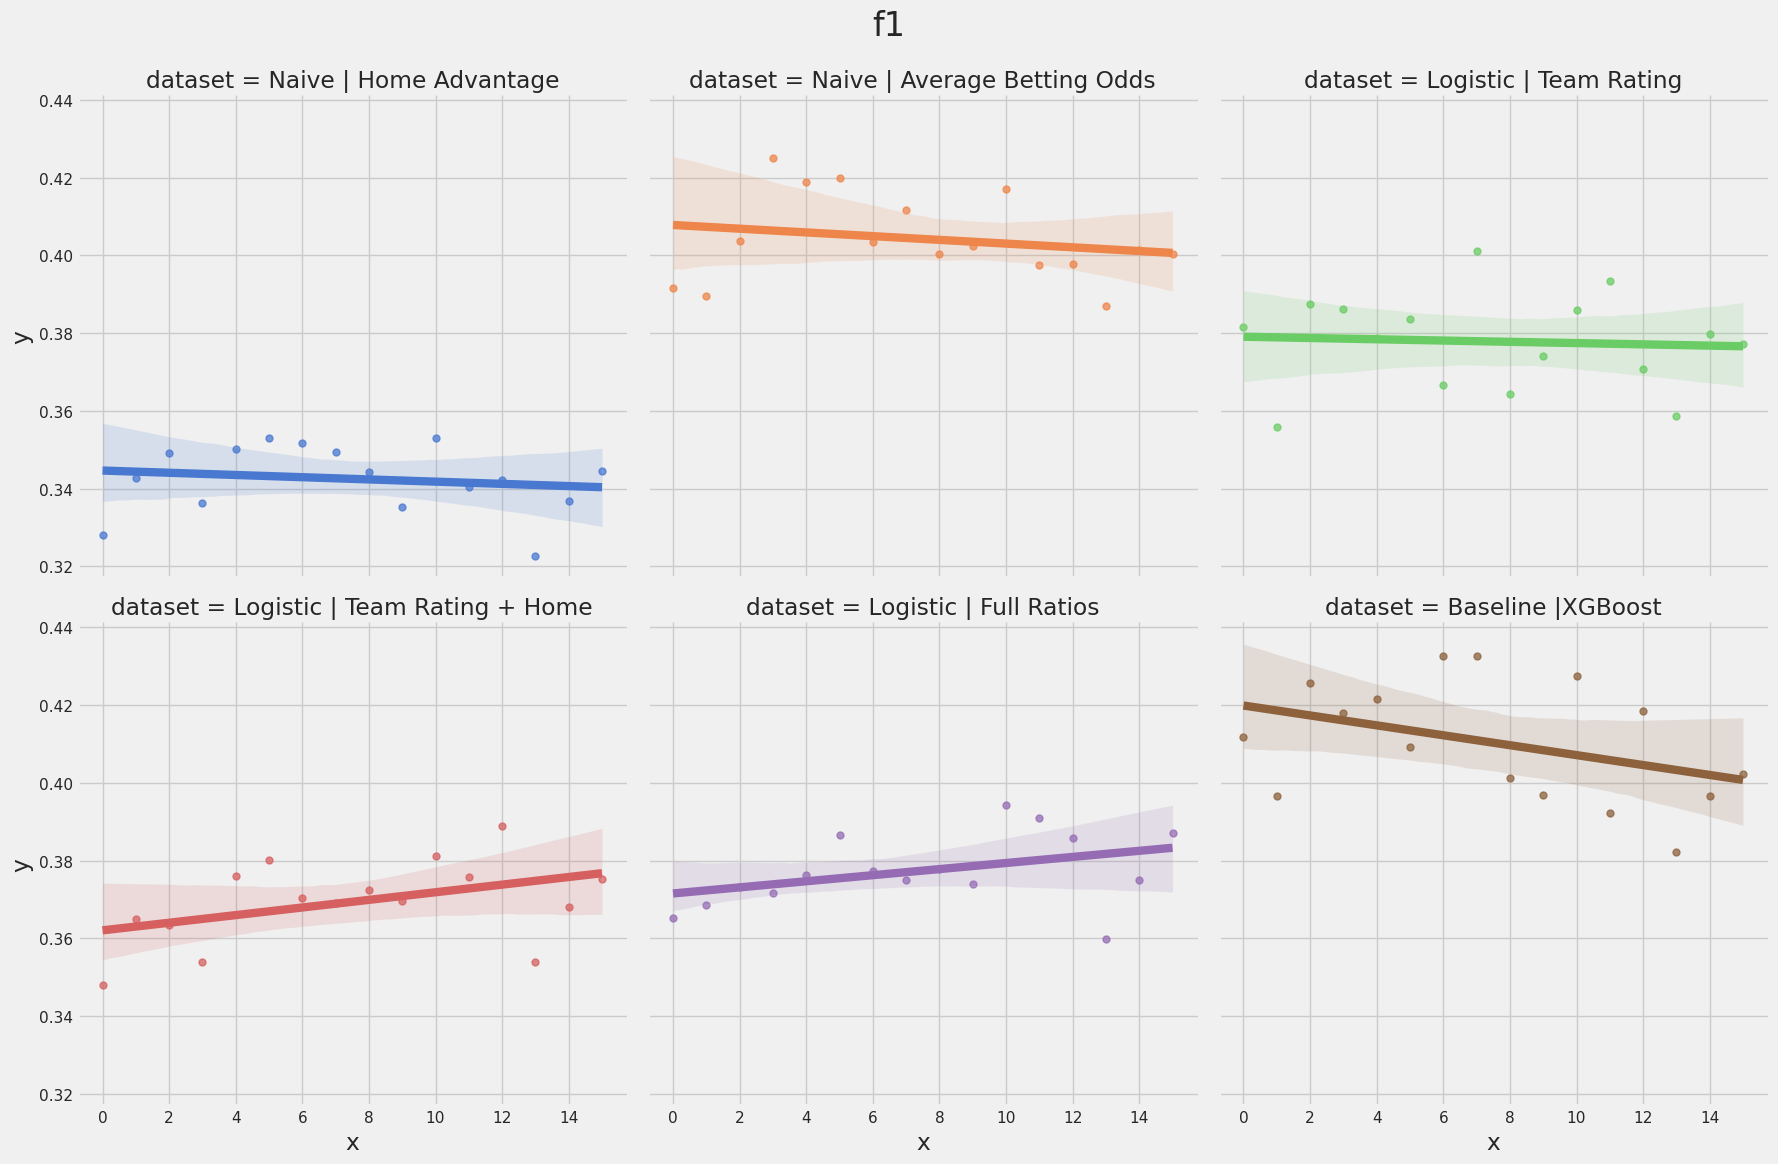

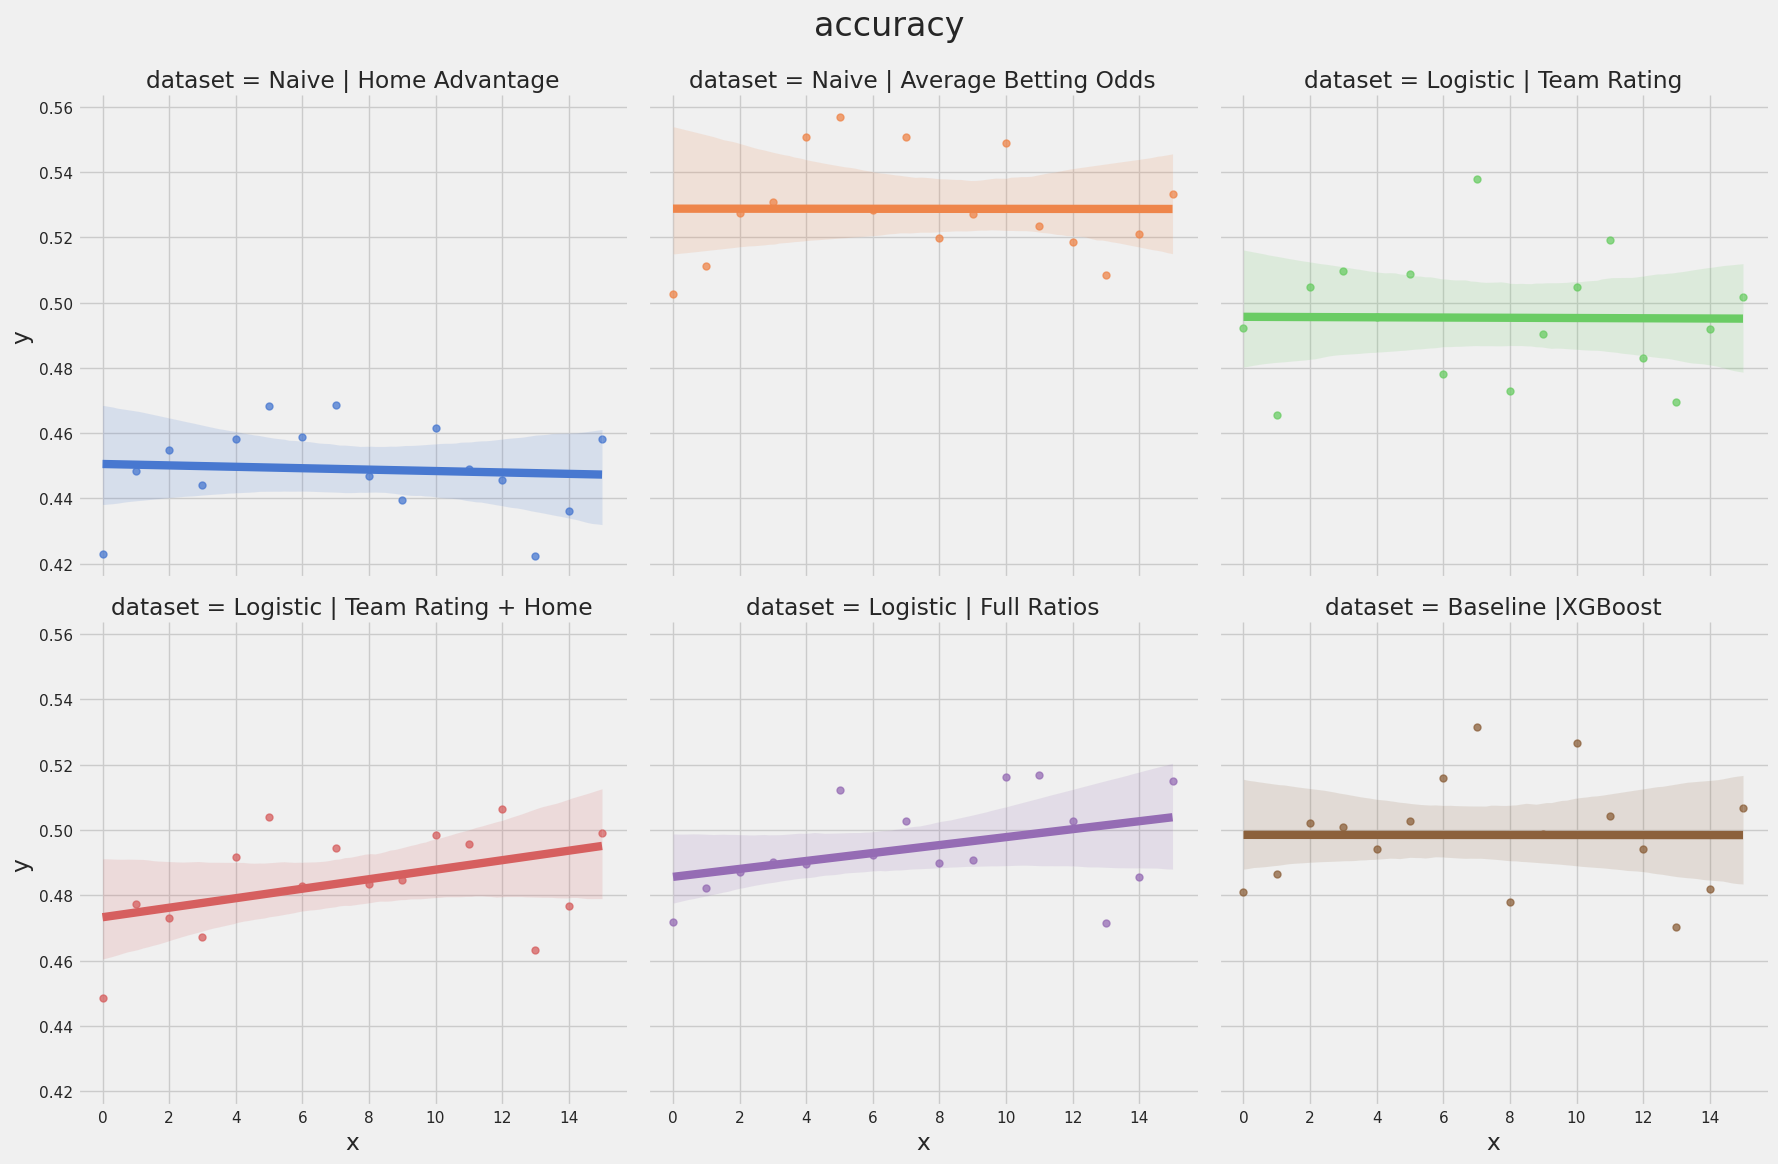

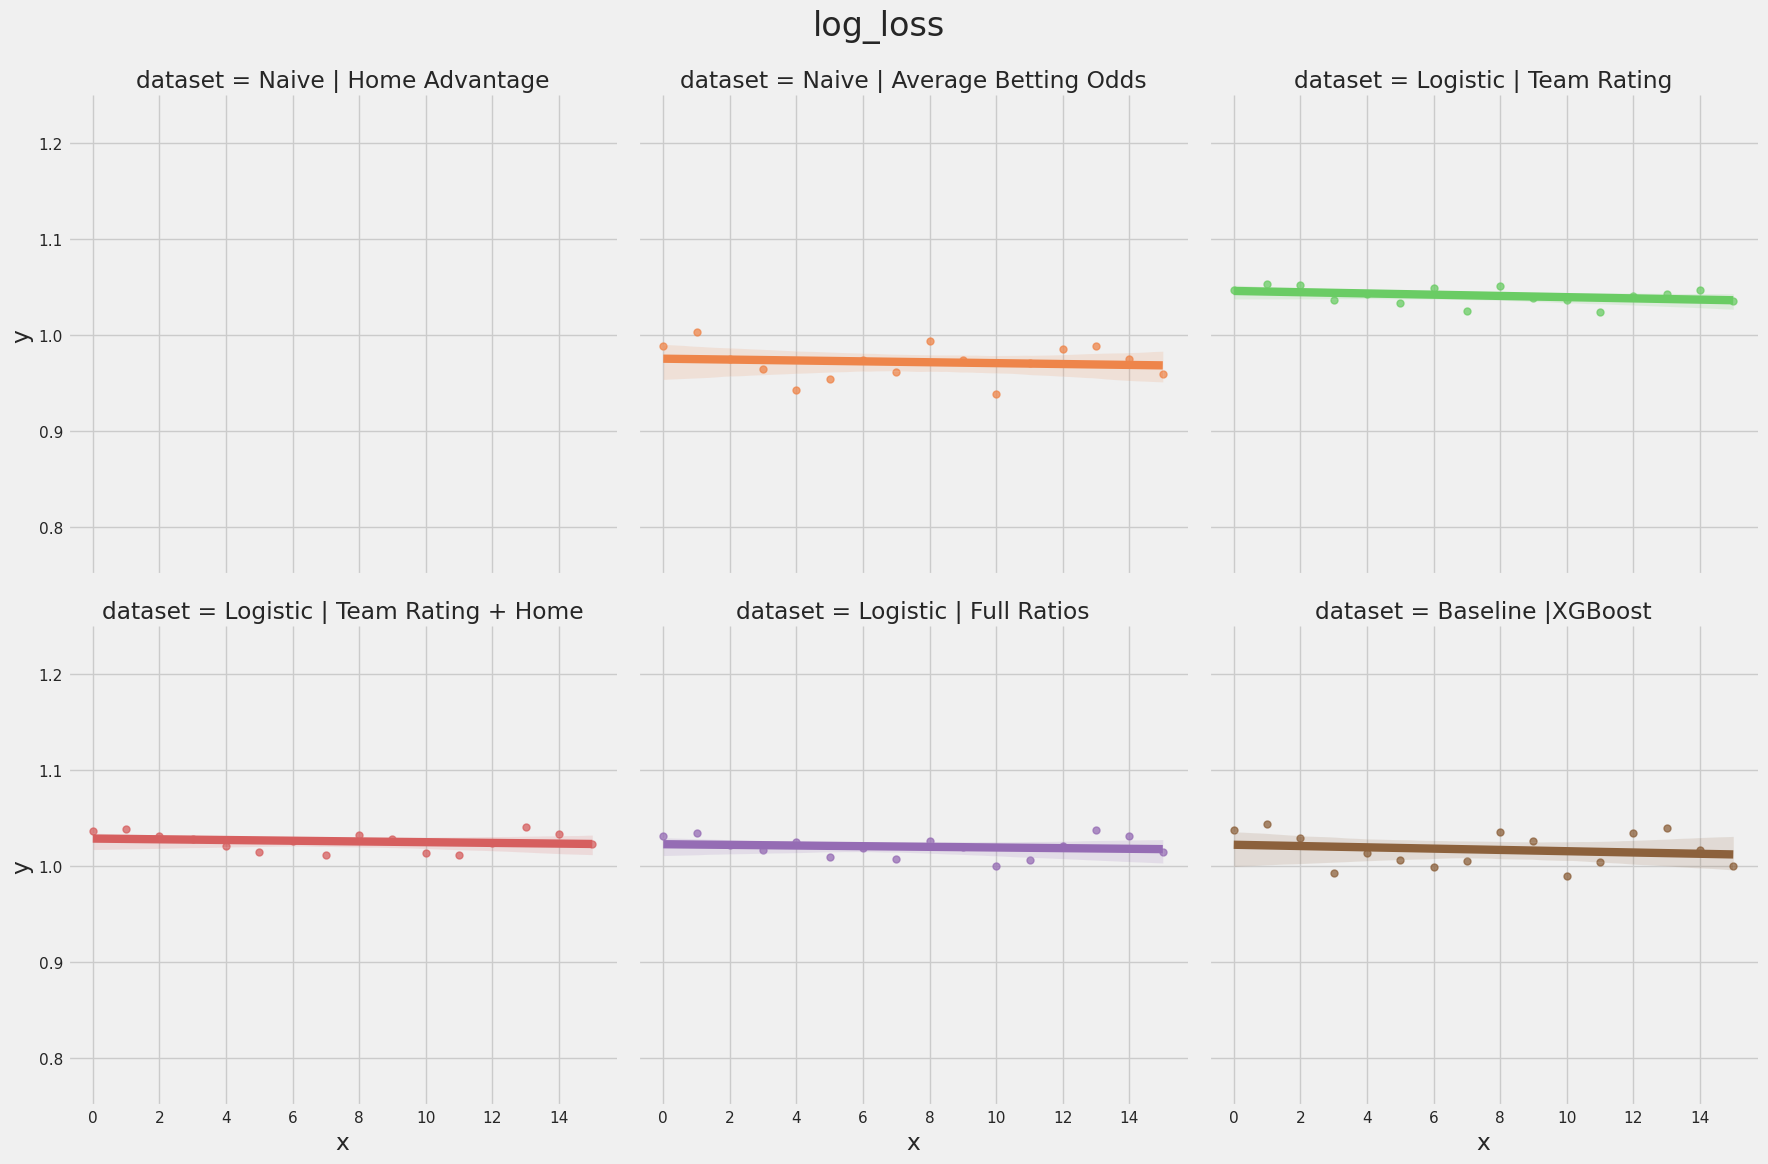

In [17]:
for metric, data in metrics_time_viz_dfs.items():
    _df = pd.DataFrame(data)

    g = sns.lmplot(
        data=_df, x="x", y="y", col="dataset", hue="dataset",
        col_wrap=3,
        palette="muted",
        # ci=25,
        # robust=True,
        height=6,
        scatter_kws={"s": 25, "alpha": 0.75}
    )
    
    if metric == "log_loss":
        g.set(ylim=(0.75, 1.25))

    
    plt.subplots_adjust(top=0.9) 
    plt.figtext(0.5, 0.95, metric, ha="center", fontsize=24)
    
    plt.show()


The main thing to note is the significant variance in f1 scores both between different model and different number of chunks. The performance of XGBoost decreased over time while it's the opposite for the Logistic model.

#### Comparing Model Performance

We can use the odds provided by betting companies (averaged for this model) and just use a dummy model which would always predict a win for the home team as baselines. Realistically we can't expect to beat the models used by betting companies so the best we can expect is that the performance of our model would be significantly better than the "Home Advantage" model and relatively close to the "Betting Odds" model.

As relatively simple Logistic model which just uses home advantage variables in addition to the ratio of the sum of player rating for either team (based on the FIFA games) performs almost as well as the XGBoost model which uses many more features most of which are derived/combined from multiple variables in the source dataframe. Superficially this might indicate that the XGBoost model is superflous because a much simpler model is almost just as good, however we don't think that's the case. There are to main reasons why the XGBoost might be more suitable for our use case:

- XGBoost has a better f1 score.
- It also is much more accurate at predicting probabilities. Due to the nature of out problem (building a model which would allow us to create a profitable betting strategy) accurately classifying win/draws/losses is not our goal at all so maximizing accu./precision/recall are not really our goals (they should just be used for initial model selection/development). Our main objective is to beat the odds provided by the betting companies by estimating the class probalities more accurately.
    - This part will be developed and examined further, but we'll see that XGBoost is much better at predicting probabilities than the much similar Logistic model.

##### Additional Details:
- XGBoost requires a significantly number of samples to provide reasonably good performance e.g. cutting number of training samples by ~80% results in signficant decrease in accuracy/F1 while Logistic Models perform relatively decently.
- Including additional variables which have relatively low predictive power can signficantly decrease the peformance of the Logistic model while XGBoost is unnafected and can generally handle them much better (so variable selection is much easier)

In [18]:
if VERBOSE:
    for k, v in confusion_matrices.items():
        display(k)
        display(confusion_matrices[k].metrics)

Further we'll look into more detailed performance of our classifier models and the difference in performance when predicting different classes. 

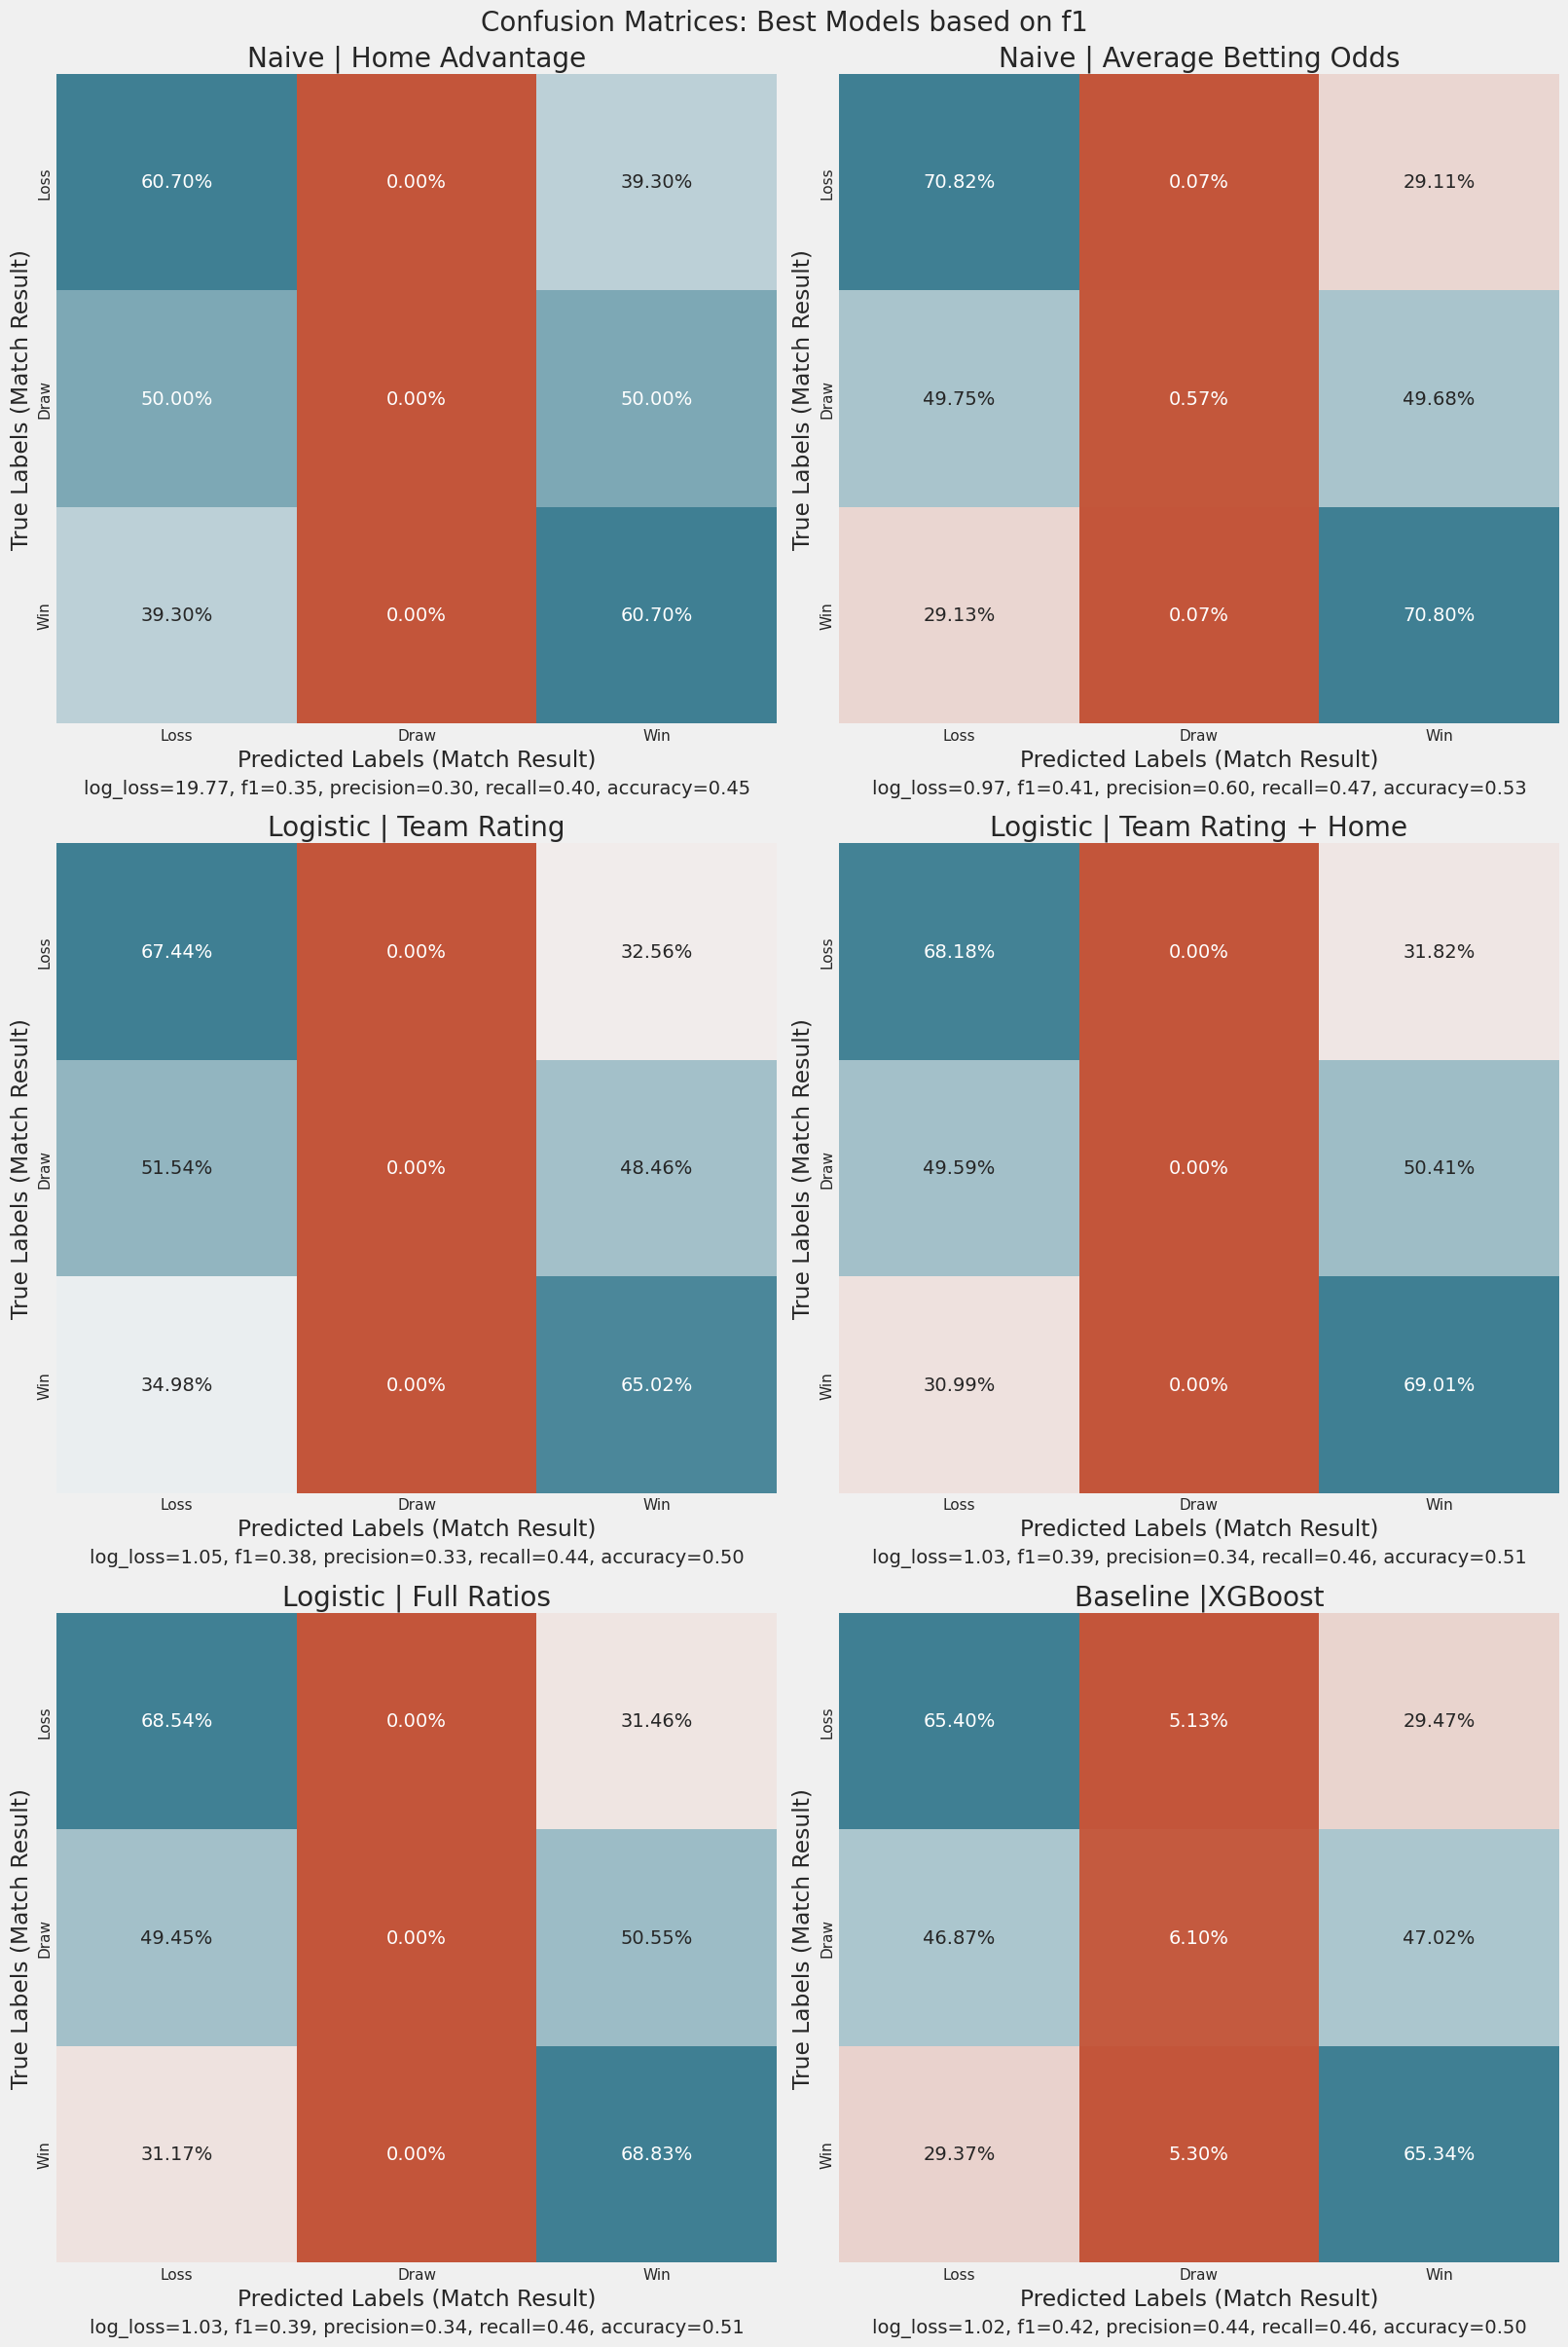

In [18]:
%matplotlib inline


importlib.reload(graph)
# sns.set_theme(style='dark', palette='pastel')

n = len(confusion_matrices)
columns = 2
rows = (n + 1) // columns
height = 8
width = height * columns

fig, axes = plt.subplots(
    rows, columns, figsize=(width, height * rows), constrained_layout=True
)
plt.suptitle("Confusion Matrices: Best Models based on f1", fontsize=20)

confusion_matrix_labels = ["Loss", "Draw", "Win"]
confusion_matrix_axis_label = "Match Result"


def make_annotations(cv_info: dict):
    return f"log_loss={cv_info['log_loss']:.2f}, f1={cv_info['f1']:.2f}, precision={cv_info['precision']:.2f}, recall={cv_info['recall']:.2f}, accuracy={cv_info['accuracy']:.2f}"


axes_flat = axes.flatten()
for i, (model_key, matrix_data) in enumerate(confusion_matrices.items()):
    graph.confusion_matrix_plot(
        confusion_matrices[model_key],
        title=model_key,
        axis_label=confusion_matrix_axis_label,
        ax=axes_flat[i],
        labels=confusion_matrix_labels,
        annotations=make_annotations(confusion_matrices[model_key].metrics),
    )

# Hide any unused axes
for j in range(i + 1, len(axes_flat)):
    axes_flat[j].axis("off")

plt.show()

Because only about 25% of all games end in a draw and there seemingly are no factors which would influence the likelihood of a game ending in a draw (loss, draw, win is effectively a ordinal variable) we can't really use betting odds to predict draws because win/loss for one of the teams is always a more likely outcome.

This is confirmed by all of our models. Interestingly XGBoost tries to predict draws in some cases but with very poor accuracy while Logistic models only predict wins or draws. This might indicate that Logistic models might perform better when predicting probabilities because their results are more similar to those achieved by betting company models (however later we'll see that that's not necessarily the case).

In [19]:
display(Markdown("##### Probability of game ending in a draw by league:"))
overall_prob = pd.DataFrame(
    {"Probability": [full_df["result"].eq(0).mean()]}, index=["Overall"]
)
league_probs = (
    full_df.groupby("league_name")["result"]
    .apply(lambda x: (x == 0).mean())
    .to_frame("Probability")
)
output_df = round(pd.concat([overall_prob, league_probs]), 2)

with pd.option_context("display.max_rows", None, "display.max_columns", None):
    display(output_df)

##### Probability of game ending in a draw by league:

,Probability
Overall,0.25
Belgium Jupiler League,0.25
England Premier League,0.26
France Ligue 1,0.28
Germany 1. Bundesliga,0.24
Italy Serie A,0.26
Netherlands Eredivisie,0.24
Poland Ekstraklasa,0.27
Portugal Liga ZON Sagres,0.26
Scotland Premier League,0.25


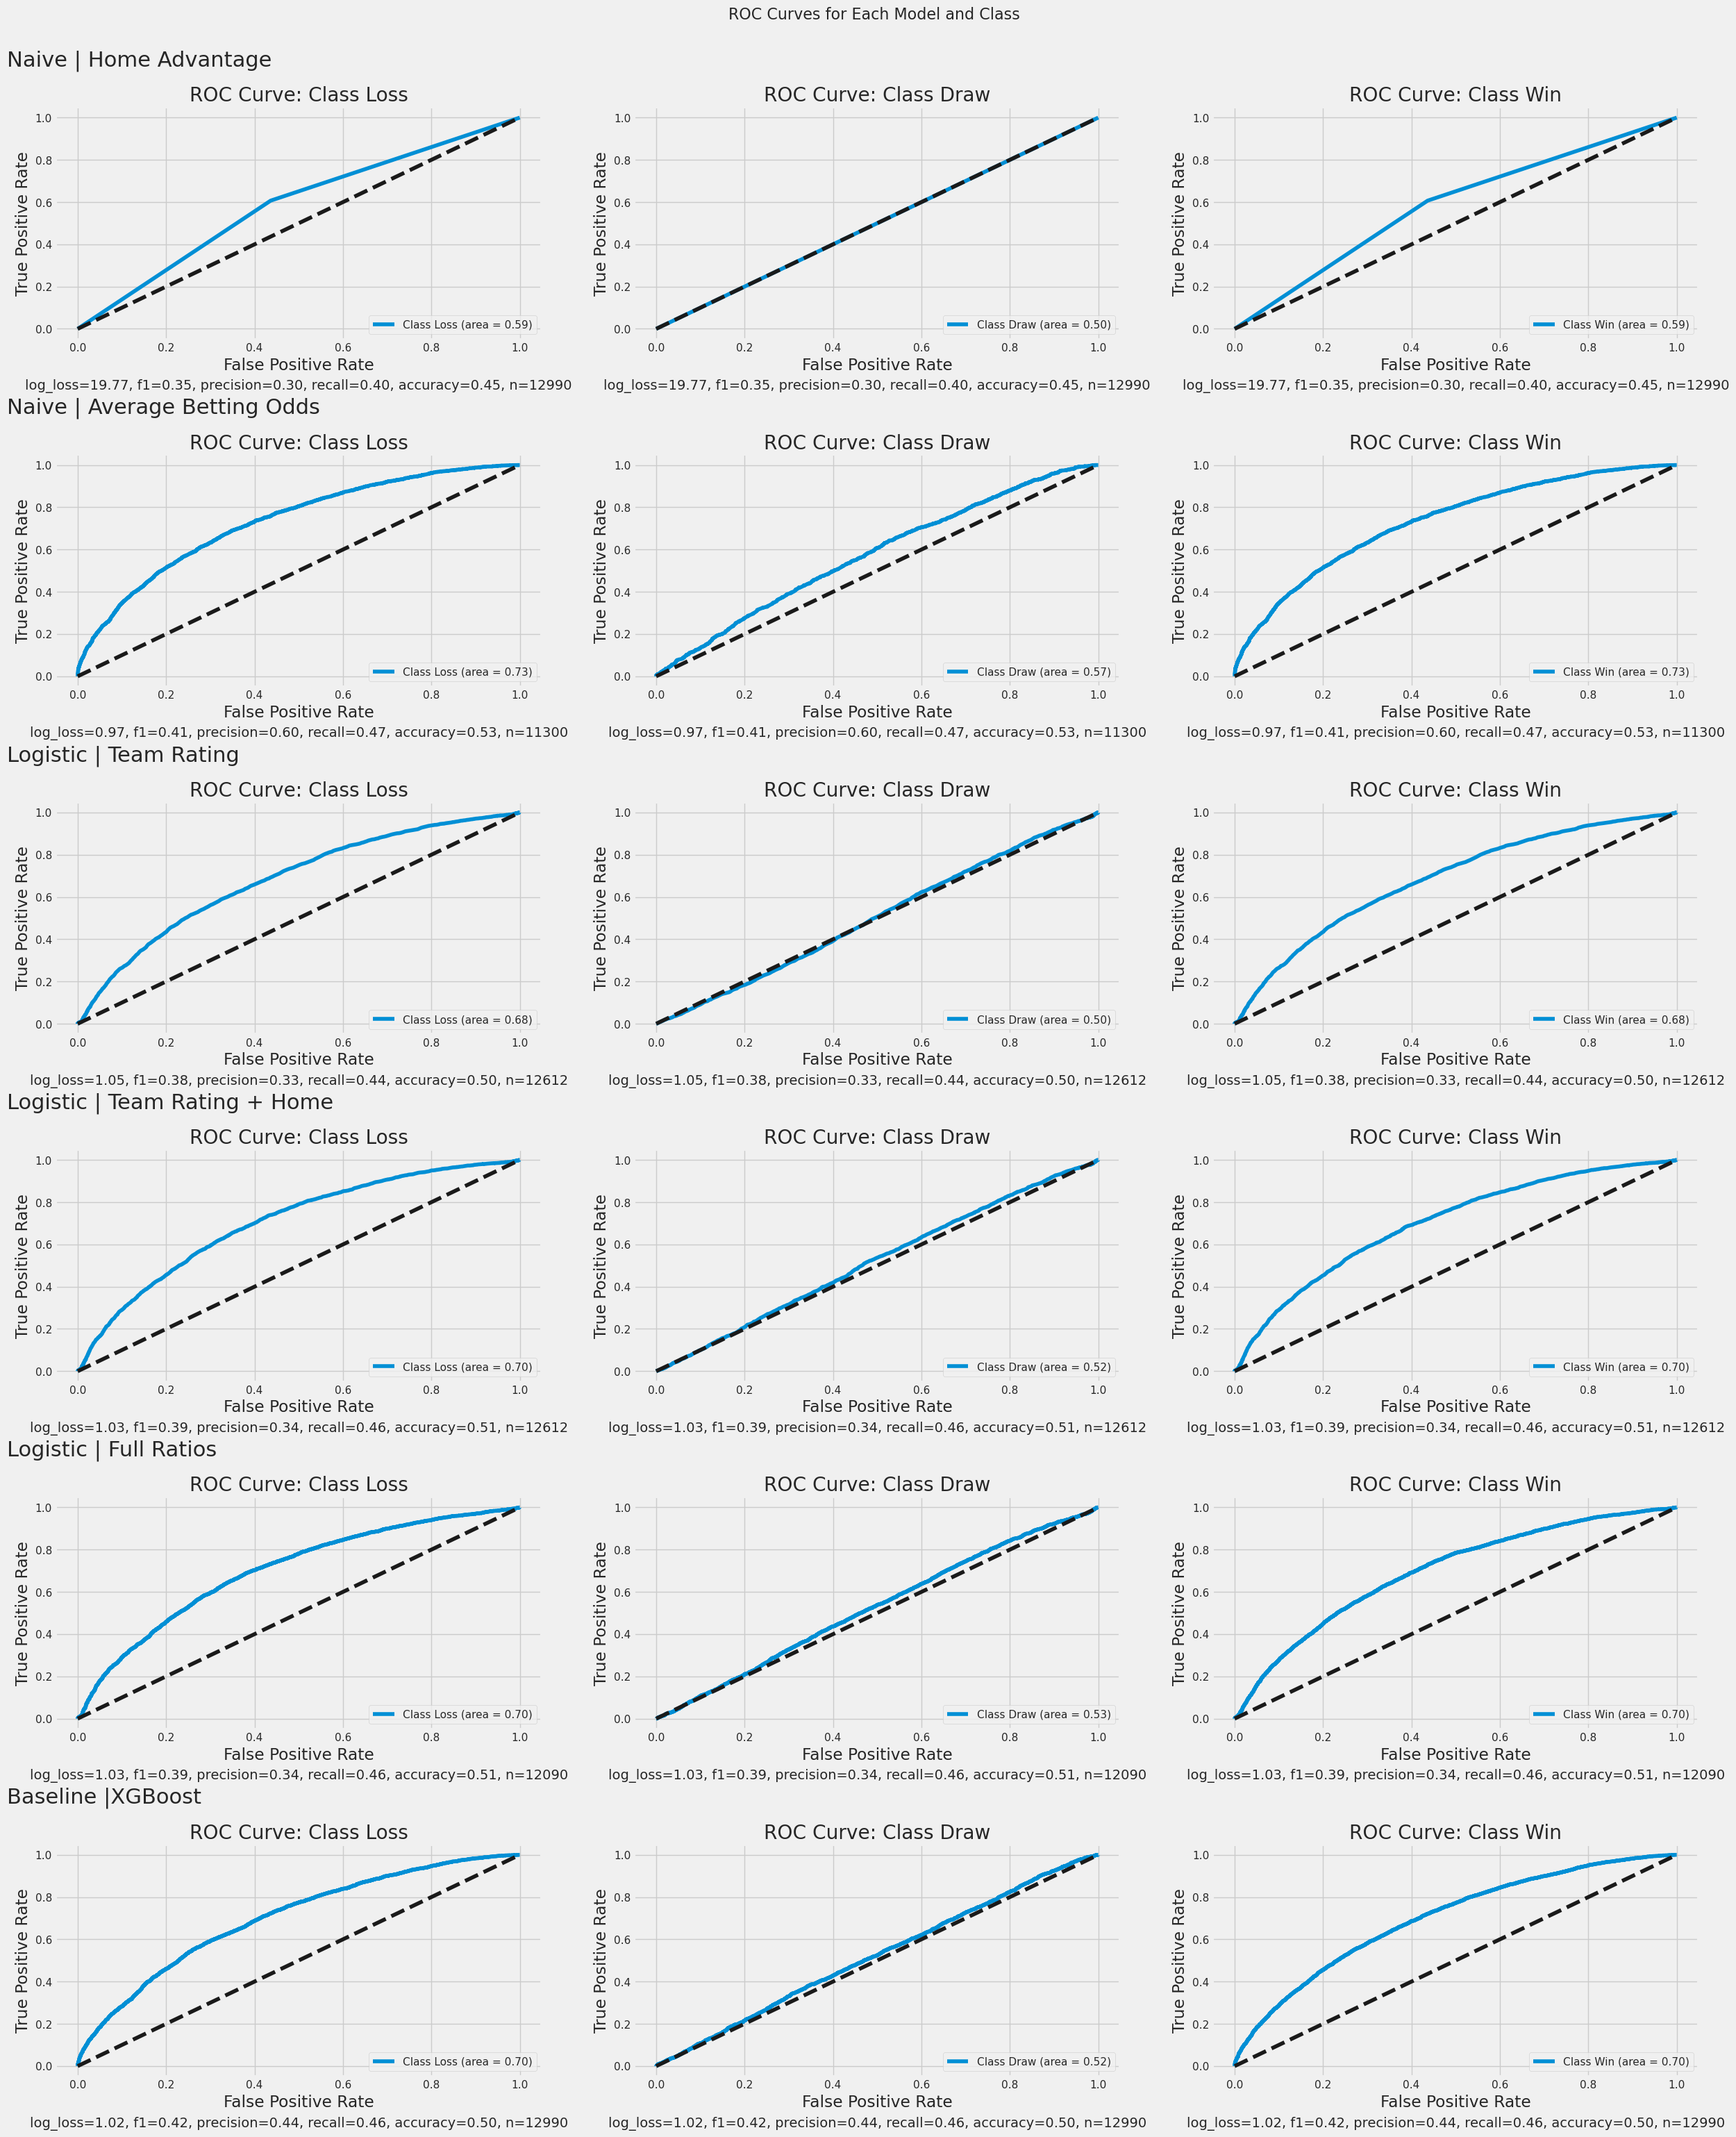

In [20]:
import matplotlib.pyplot as plt

importlib.reload(graph)

n_classes = 3  # Assuming 3 classes [0, 1, 2]
fig, axes = plt.subplots(
    len(confusion_matrices),
    n_classes,
    figsize=(25, 5 * len(confusion_matrices)),
    constrained_layout=True,
)
plt.suptitle("ROC Curves for Each Model and Class", fontsize=16, y=1.02)

for i, (model_key, matrix_data) in enumerate(confusion_matrices.items()):
    y_true = matrix_data.y_test
    y_probs = matrix_data.probabilities

    if n_classes % 2 == 0:
        middle_plot_index = n_classes // 2 - 1
    else:
        middle_plot_index = n_classes // 2

    axes[i, 0].text(
        -0.1,
        1.2,
        model_key,
        ha="left",
        va="center",
        transform=axes[i, 0].transAxes,
        fontsize=22,
    )

    for class_idx in range(n_classes):
        valid_indices = y_probs.iloc[:, class_idx].dropna().index
        y_true_binary = (y_true.loc[valid_indices] == class_idx).astype(int)
        y_probs_filtered = y_probs.loc[valid_indices, class_idx]

        n = y_true_binary.shape[0]  # Row count for the class
        graph.roc_curve_plot(
            y_true=y_true_binary,
            y_probs=y_probs_filtered,
            ax=axes[i, class_idx],
            labels=confusion_matrix_labels,
            annotations=make_annotations(matrix_data.metrics),
            class_idx=class_idx,
            n=n,
        )

plt.show()

In [21]:
# benchmark_model_target_log = "Logistic | Team Rating + Home"
benchmark_model_target_log = "Logistic | Full Ratios"
cm_model_test_last_log: ModelTrainingResult = confusion_matrices[
    benchmark_model_target_log
]

benchmark_model_target_xgb = "Baseline |XGBoost"
cm_model_test_last_xgb: ModelTrainingResult = confusion_matrices[
    benchmark_model_target_xgb
]

odds_model_target = "Naive | Average Betting Odds"
odds_model_test_last: ModelTrainingResult = confusion_matrices[
    odds_model_target
]

One-vs-Rest ROC curves (e.g. Loss vs Draw/Win etc.) show a similar picture to the confusion matrix. Values of around 0.7 for Win/Loss predictions indicate a moderate discriminatory ability for all of our models. For Draw the AUC is only slightly above 0.5 which would indicate that their performance is almost the same as guessing at random. 

/home/paulius/data/projects/football_m2_s4/workbench/src/graph.py:631: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(


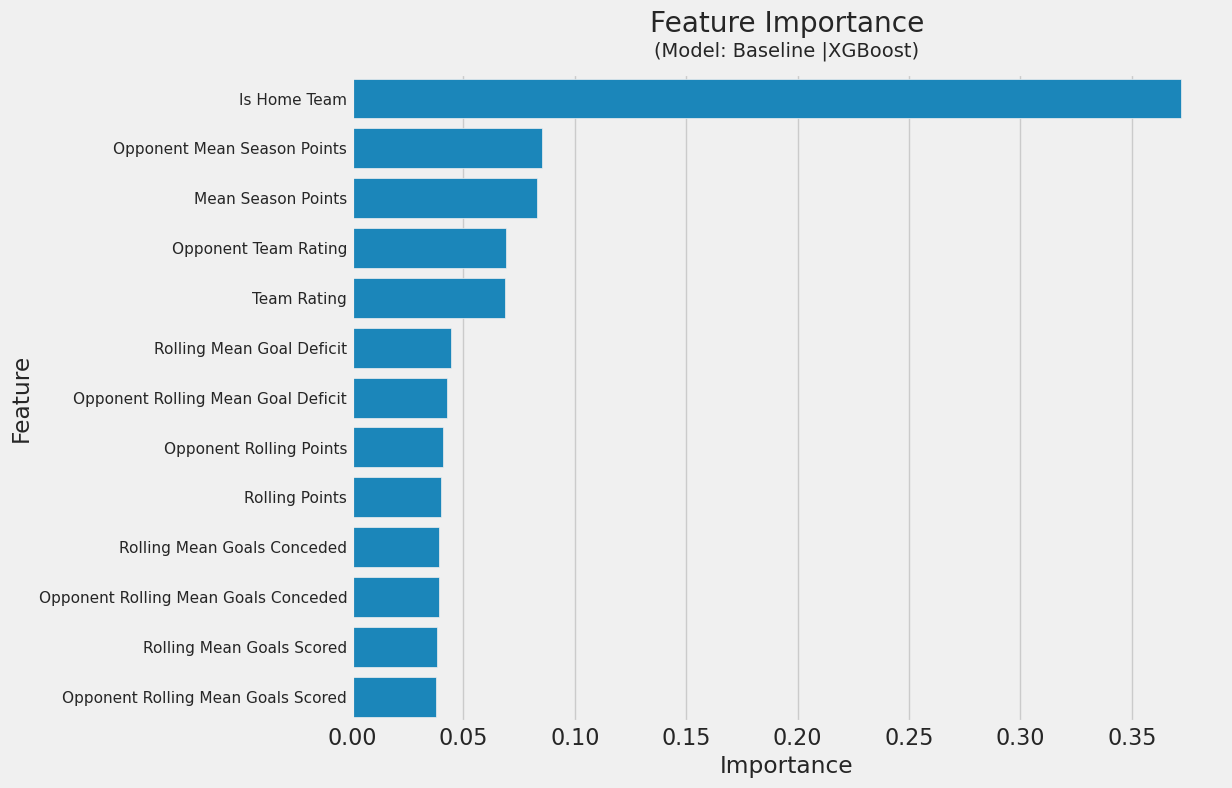

In [22]:
importlib.reload(graph)

feature_importances = cm_model_test_last_xgb.feature_importances
graph.render_feature_importances_chart(
    feature_importances, title="Feature Importance", subtitle=benchmark_model_target_xgb
)

It's somewhat disappointing but as could be expected whether the team is playing at home or not is still the best predictor of a match outcome. However, various other features we've built still have some predictive power. They do not seem to effect the classification accuracy itself but it's possible that they have contributed to the XGBoost model being able to predict probabilities more accurately.  

In [23]:
#### TODO: just add an XGBoost config with only home/rating
#### TODO: ideally also add logistic configs with rolling goal, points etc. ratios

#### Measuring Accuracy Probability Prediction

*The Logarithmic Loss, is a performance metric for evaluating the probabilistic accuracy of classifier models. The log loss ranges from 0 to ∞. A perfect model would have a log loss of 0. Higher values indicate worse performance.*

*Log loss not only penalizes for wrong predictions but also takes into account how confident the predictions were. If the model is highly confident (high probability) about an incorrect prediction, it incurs a higher penalty.*

*0: Perfect predictions. The predicted probability for the actual class is 1.*
*<1: Good predictions. Indicates high probability assigned to the actual class.*
*>1: Poor predictions. Indicates lower probability for the actual class, or high confidence in wrong predictions.*
*Increases Rapidly with Confidence in Wrong Predictions: Because it's logarithmic, the penalty escalates quickly when the model confidently predicts the wrong class.*
*Comparing Models: Lower log loss values are better. When comparing models, the one with a lower log loss should generally be preferred.*

*Not Threshold-dependent: Unlike accuracy, which depends on a threshold to determine the class label, log loss evaluates the raw probabilities, giving a more nuanced view of the model's performance.*


In [24]:
if VERBOSE:
    full_df[[c for c in full_df.columns if "odds" in c] + ["result"]][
        "result"
    ].value_counts()

In [25]:
if VERBOSE:
    importlib.reload(validation)
    validation.calculate_brier_score(full_df)

In [26]:
if VERBOSE:
    importlib.reload(simulation)
    simulation.calculate_company_profit(full_df, 1000000)

In [27]:
log_model_probs = cm_model_test_last_log.probabilities_match_id
xgb_model_probs = cm_model_test_last_xgb.probabilities_match_id

In [28]:
if VERBOSE:
    full_df[full_df["match_api_id"] == 2060427]

In [29]:
importlib.reload(validation)
probs_benchmark_log = validation.benchmark_model_probs(log_model_probs, full_df_model)
probs_benchmark_xgb = validation.benchmark_model_probs(xgb_model_probs, full_df_model)

/home/paulius/data/projects/football_m2_s4/workbench/src/validation.py:128: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  combined_df[["prob_win", "prob_draw", "prob_loss"]] /= total_prob[:, None]
/home/paulius/data/projects/football_m2_s4/workbench/src/validation.py:128: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  combined_df[["prob_win", "prob_draw", "prob_loss"]] /= total_prob[:, None]


In [30]:
if VERBOSE:
    probs_benchmark_log

In [31]:
if VERBOSE:
    probs_benchmark_xgb

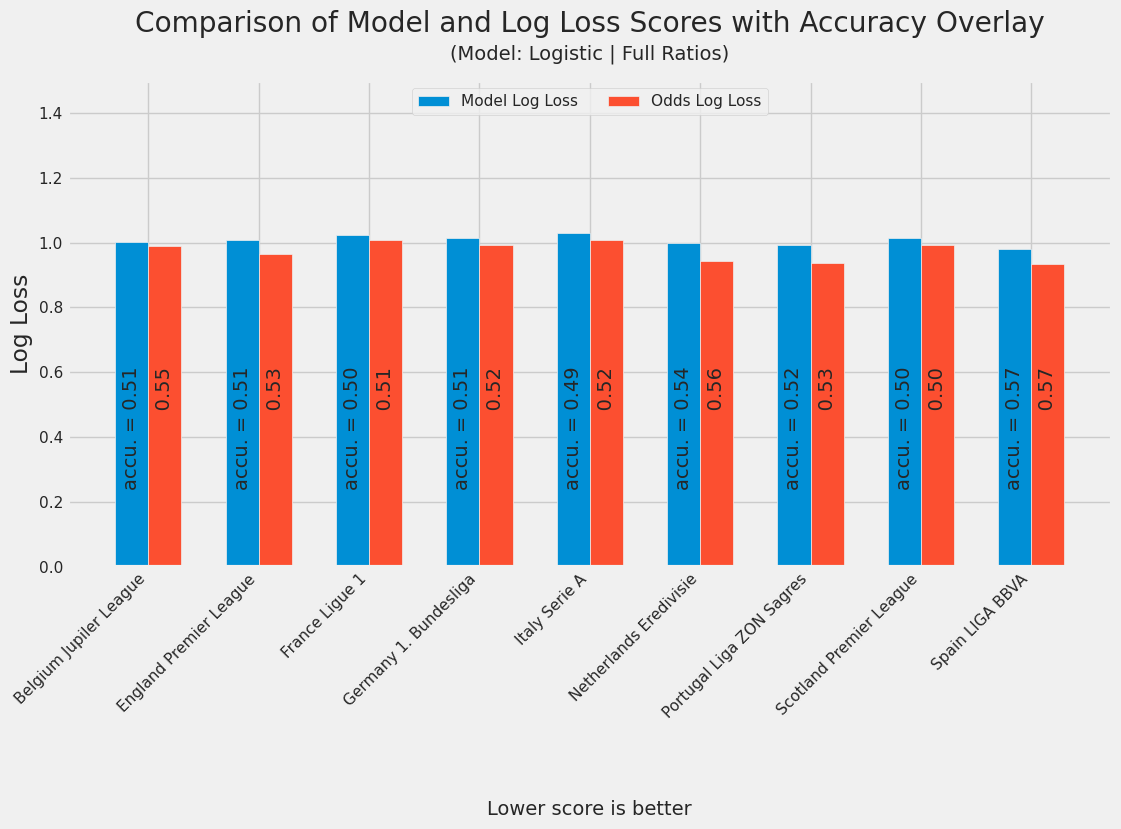

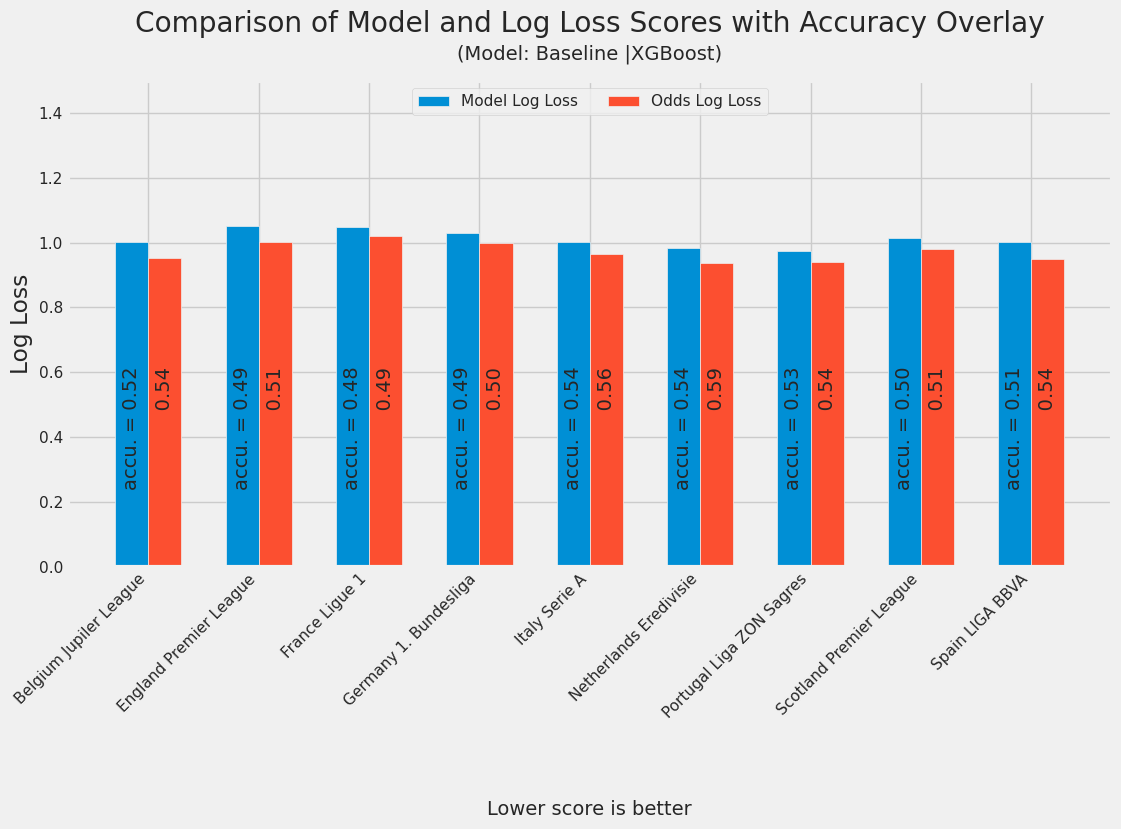

In [32]:
importlib.reload(graph)
graph.render_by_league_beanchmark_scores(
    probs_benchmark_log, metric="log_loss", model_name=benchmark_model_target_log
)
graph.render_by_league_beanchmark_scores(
    probs_benchmark_xgb, metric="log_loss", model_name=benchmark_model_target_xgb
)

We'll start with examining the performance of our model in relation to the average betting odds baseline model across  different leagues

#### Beating the Betting Companies

We can see that our model generally under-performs compared to the odds offered by betting companies across all leagues. However, this does not mean that we can't build profitable betting strategy using our model, considering:

- We don't need to bet on every single match, we can bet only matches where our model can predict the outcome with a relatively high probability.

To achieve this, we will:

- Select a specific subset of matches where our model demonstrates a significantly high probability for a particular outcome (above a defined threshold, T).
- Compare the difference between the odds predicted by our model and those offered by betting companies.
- Use the result to determine the optimal amount to bet on each individual match.



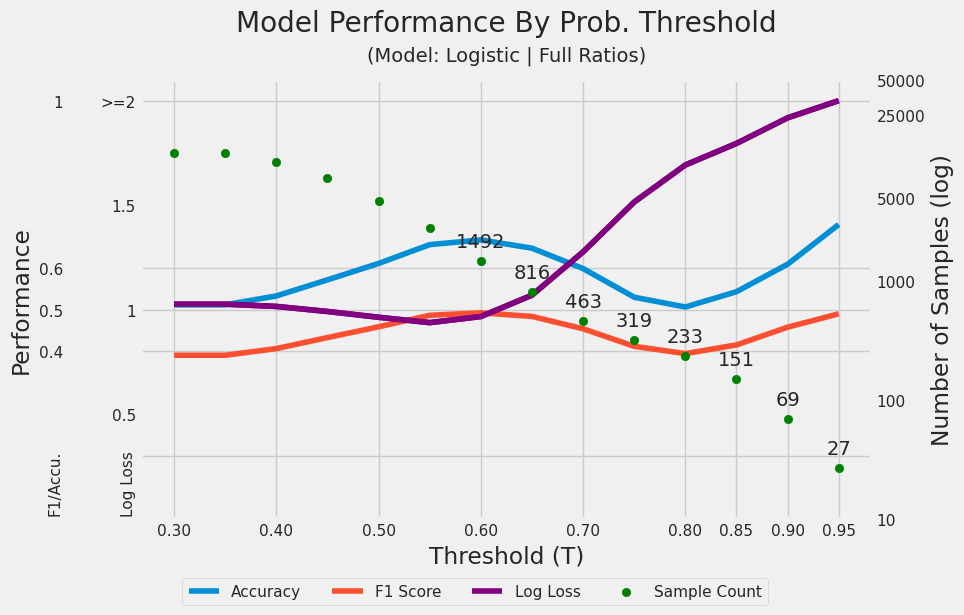

In [33]:
importlib.reload(graph)
graph.plot_threshold_metrics(
    cm_model_test_last_log, 0.3, 1.0, model_name=benchmark_model_target_log
)

This plot shows how the performance of a model changes if we exclude all the rows from the training dataset where the highest probability for any class is below a certain threshold T (e.g. ordinarily for instance if the model predicts these probabilities for a match, loss = 32%, draw = 32%, won = 36% all this information would be lost if we're using standard classifier model metrics like accuracy yet from out perspective betting on such games wouldn't make a lot of sense).

We can see the performance of the Logistic model improves only slightly if we increase the threshold to 50-60% yet it actually start declining if we increase it further making this model almost entirely useless for our use case.

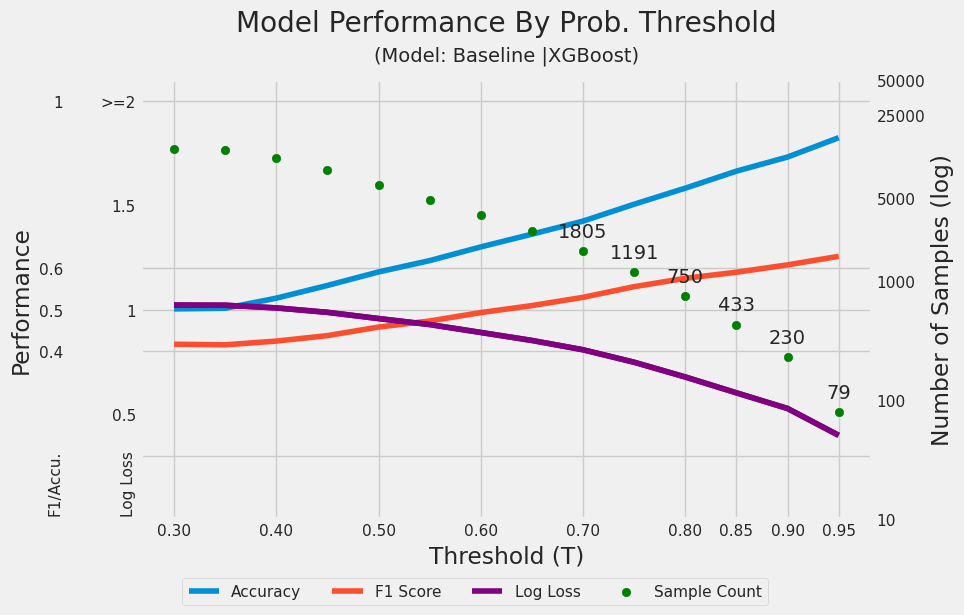

In [34]:
graph.plot_threshold_metrics(
    cm_model_test_last_xgb, 0.3, 1.0, model_name=benchmark_model_target_xgb
)

/home/paulius/miniconda3/envs/rapids_v2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/home/paulius/miniconda3/envs/rapids_v2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/home/paulius/miniconda3/envs/rapids_v2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/home/paulius/miniconda3/envs/rapids_v2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(
/home/paulius/miniconda3/envs/rapids_v2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:

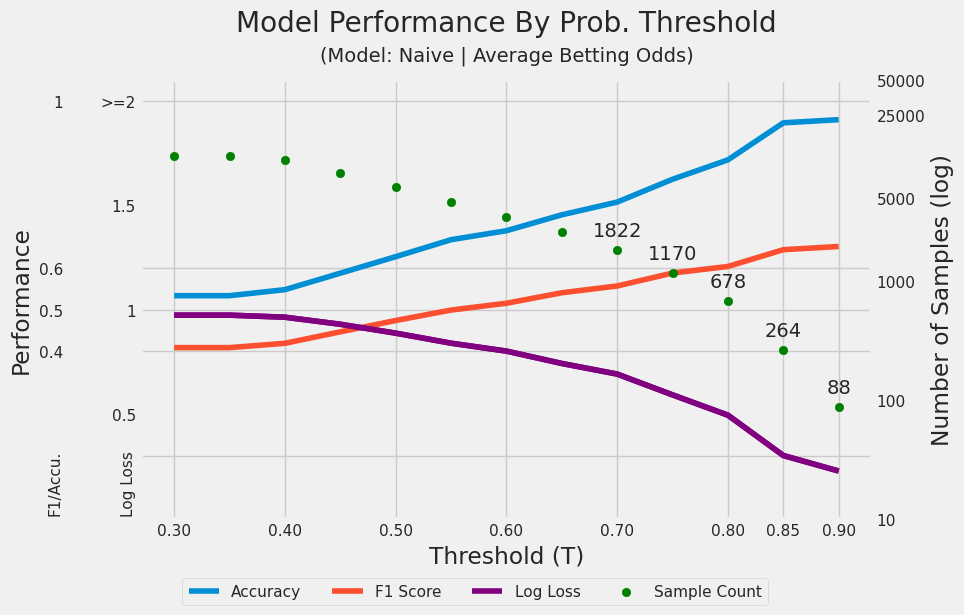

In [35]:
importlib.reload(graph)
graph.plot_threshold_metrics(
    odds_model_test_last, 0.3, 1.0, model_name=odds_model_target
)

On the other hande the more complex XGBoost model seems to be much better at predicting probabilities. If we only include matches with higher than .95 probabilities we can increase the accuracy of our predictions up to almost 90% (precision/recall scores remain low but we might be able to mitigate that to some extent).

The number of samples with T = 0.90 seems sufficient, betting on 238 matches is probably enough to get evaluate our betting strategy. However we could expiriment with sighlty lower thresholds and/or increasing the test sample.


<Figure size 640x480 with 0 Axes>

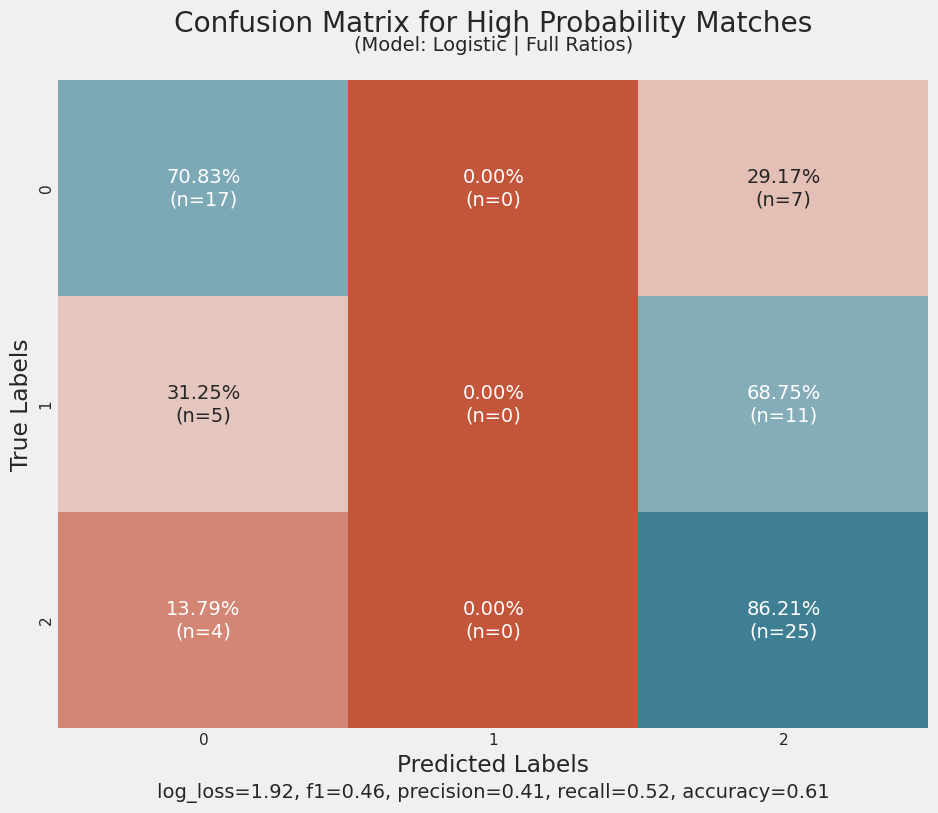

<Figure size 640x480 with 0 Axes>

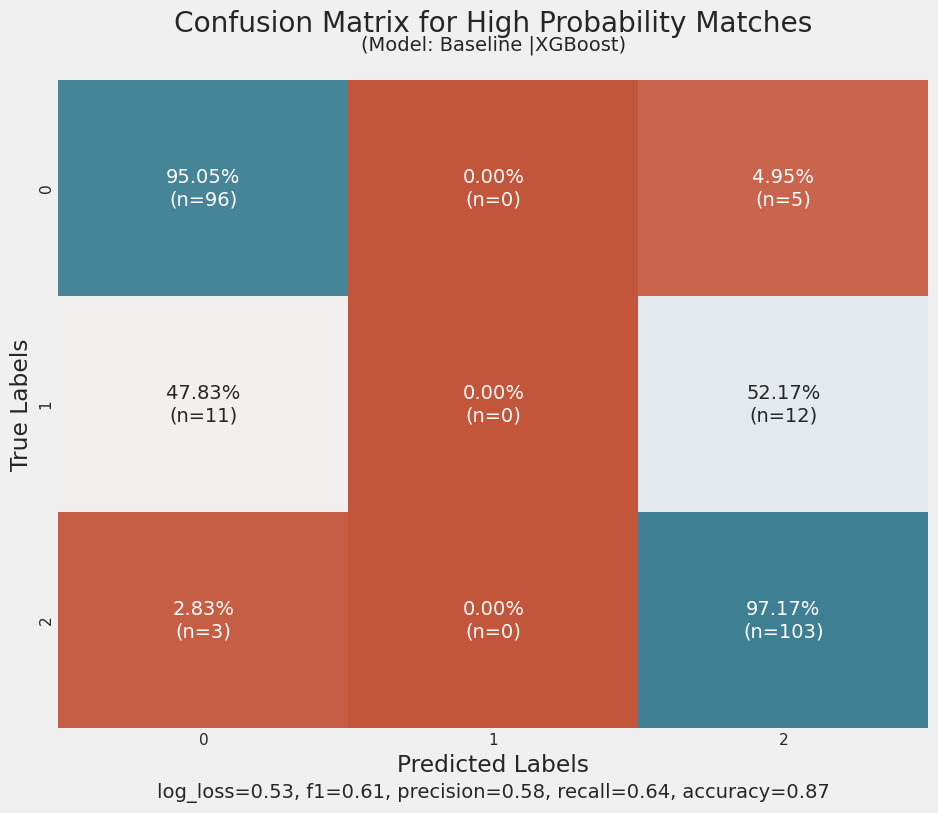

In [36]:
importlib.reload(validation)
importlib.reload(graph)
T = 0.9  # Probability threshold, include only rows where any prob. is higher than T.

for _model in [
    (benchmark_model_target_log, cm_model_test_last_log),
    (benchmark_model_target_xgb, cm_model_test_last_xgb),
]:
    filtered_model_training_result: ModelTrainingResult = (
        validation.filter_matches_above_threshold(_model[1], T)
    )

    graph.confusion_matrix_plot(
        model_info=filtered_model_training_result,
        title="Confusion Matrix for High Probability Matches",
        subtitle=_model[0],
        annotations=make_annotations(filtered_model_training_result.metrics),
        include_sample_count=True,
    )

    plt.show()

Even with an increased threshold the XGBoost model  struggles distinguishing between draws and wins/losses. On the positive side almost no wins or losses are misclassified as losses or win respectively.

In [37]:
subset_probs = filtered_model_training_result.probabilities_match_id

if VERBOSE:
    validation.benchmark_model_probs(subset_probs, full_df_model, by_league=False)

In a future iteration we could experiment by try to design a strategy which would allow betting on multiple events like win+draw instead of just single outcome that might possible partially alleviate this issue. For now, we'll just bet on a single outcome (win or loss).

While betting a fixed amount on every game we managed to make a slight profit. However, this approach is not ideal because we're betting the same amount regardless on how much our predicted odds differ from those provided by betting companies. Instead, we should change our bet amount for games where the predicted outcome and the betting company odds differ to a large degree.

This is a complicated problem to solve.  Calculates for the optimal bet size should be based on our bankroll, the odds, and your estimated probability of winning. 
`Kelly Criterion` is a commonly used formula to solve this problem, so we'll try to use it.

In [38]:
importlib.reload(simulation)
bet_strats = {
    "Naive (fixed amount per bet)": dict(use_kelly=False),
    "Use (adjusted 0.8/1) Kelly Criterion": dict(
        use_kelly=True, min_range=0.8, max_range=1
    ),
    "Use (adjusted 0.85/1.15) Kelly Criterion": dict(
        use_kelly=True, min_range=0.85, max_range=1.15
    ),
    "Use (adjusted 0.9/1) Kelly Criterion": dict(
        use_kelly=True, min_range=0.9, max_range=1
    ),
    "Use (adjusted 0.91/1.2) Kelly Criterion": dict(
        use_kelly=True, min_range=0.91, max_range=1.2
    ),
}

for key, v in bet_strats.items():
    (
        total_profit_or_loss,
        total_bet_amount,
        total_bets,
        total_valid_matches,
    ) = simulation.evaluate_betting_strategy(
        filtered_model_training_result,
        full_df_model[
            [
                "match_api_id",
                "team_id",
                "win_odds",
                "draw_odds",
                "opponent_win_odds",
                "result",
            ]
        ],
        bankroll=1000,
        **v,
    )
    return_rate = total_profit_or_loss / total_bet_amount
    print(f"\n\n --- \n{key}:")
    print(
        f"Total bets:{total_bets}/{total_valid_matches}\nTotal bet amount: {total_bet_amount:2f}\n Profit: {total_profit_or_loss:.2f}\n Return:{return_rate:.2%}"
    )



 --- 
Naive (fixed amount per bet):
Total bets:221/221
Total bet amount: 1000.000000
 Profit: 30.86
 Return:3.09%


 --- 
Use (adjusted 0.8/1) Kelly Criterion:
Total bets:221/221
Total bet amount: 10733.832842
 Profit: 380.01
 Return:3.54%


 --- 
Use (adjusted 0.85/1.15) Kelly Criterion:
Total bets:160/221
Total bet amount: 3430.006859
 Profit: 123.87
 Return:3.61%


 --- 
Use (adjusted 0.9/1) Kelly Criterion:
Total bets:84/221
Total bet amount: 3572.333641
 Profit: 175.47
 Return:4.91%


 --- 
Use (adjusted 0.91/1.2) Kelly Criterion:
Total bets:75/221
Total bet amount: 925.719984
 Profit: 52.99
 Return:5.72%


Our rate of return did improve quite a bit when using the Kelly criterion and doing some additional tweaking. So far based on this very limited testing sample it seems that it is possible to turn profit by using our model. However, additional testing and validation, specifically:
- The testing sample is very small, it's likely that a different test-train split would provide drastically different results so we should use cross-validation when benchmarking our betting strategy 
- etc.

#### Limitations and Potential Improvements:

##### Model Training and Validation
- Time based cross validation can be improved by implementing additional time based weights (so that more recent matches would have larger weight than old ones)
- We need additional testing and validation to measure the impact using random sampling might have.
- The betting strategy simulation should be expanded to use a time based cross validation approach. 
- Feature selection and engineering can be improved
    - Various other features should be tried:
        - Individual player ratings
        - Splitting total team rating by player position (attacker/midfield/defence)
    - Various other periods should be tested with rolling stats based features 